# Preprocess

In [1]:
import json
import os
from pathlib import Path
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.simplefilter('ignore')

In [2]:
ROOT_DIR = Path().resolve()
OUT_DIR = ROOT_DIR.joinpath("input", "preprocessed")
CONFIG_DIR = ROOT_DIR.joinpath("configs")
os.makedirs(OUT_DIR.joinpath("train"), exist_ok=True)
os.makedirs(OUT_DIR.joinpath("test"), exist_ok=True)
os.makedirs(CONFIG_DIR, exist_ok=True)
os.makedirs(ROOT_DIR.joinpath("input", "test"), exist_ok=True)

## 1. 学習データの前処理

Read from n20degC_Cycle_1_Pan18650PF.csv
Start from 0
Save to n20degC_Cycle_1_Pan18650PF.pickle


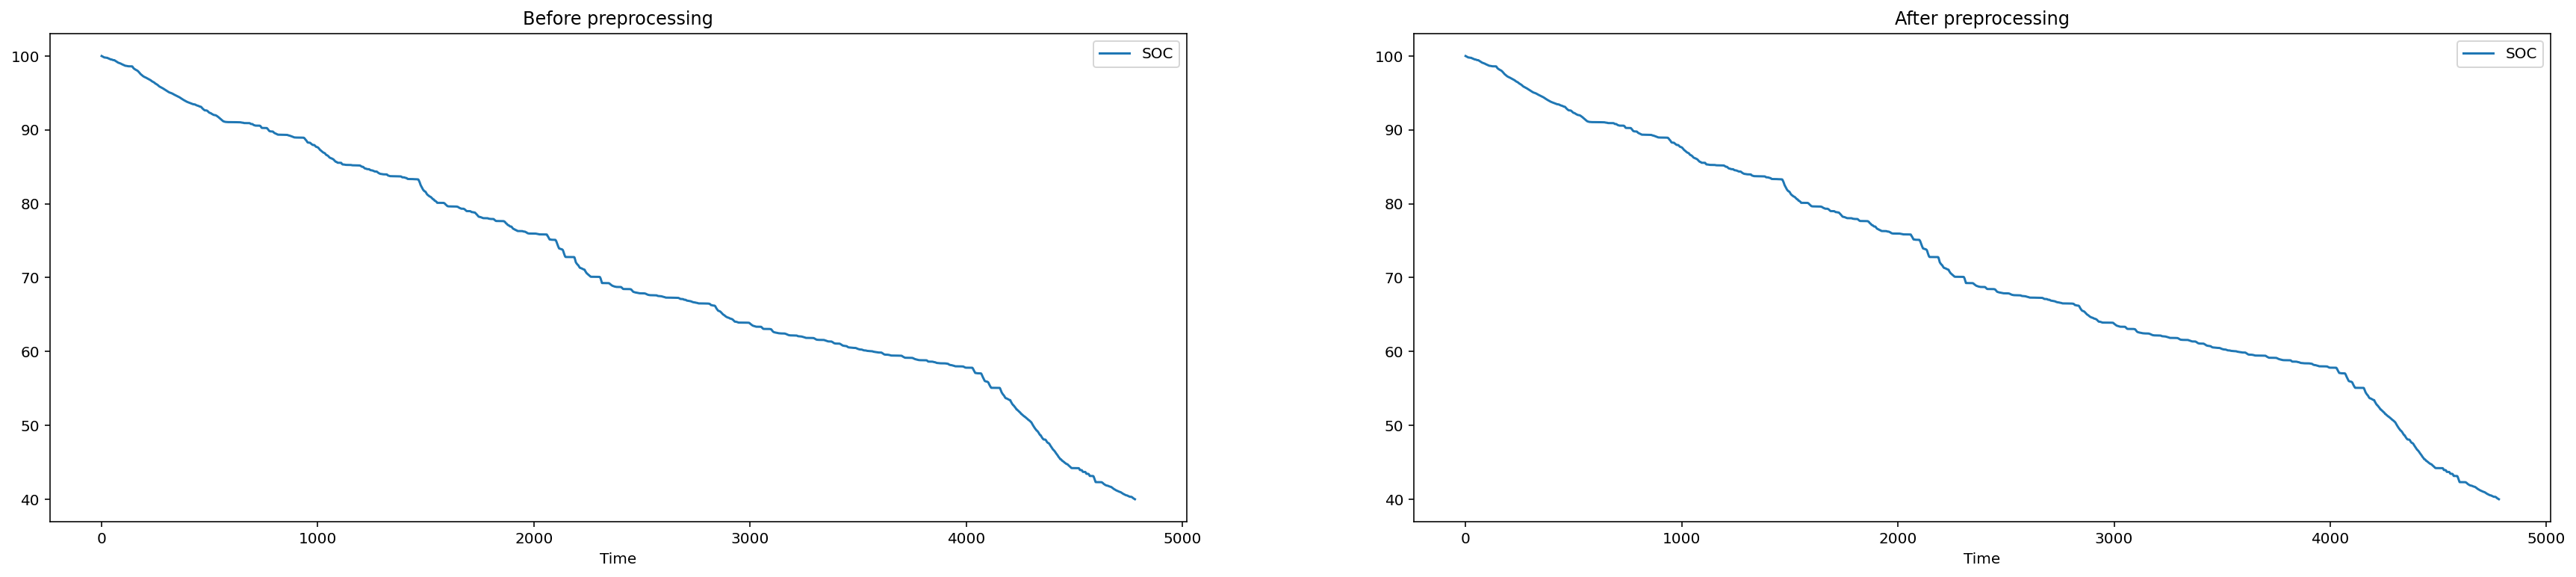

Read from p25degC_NN_Pan18650PF.csv
Start from 0
Save to p25degC_NN_Pan18650PF.pickle


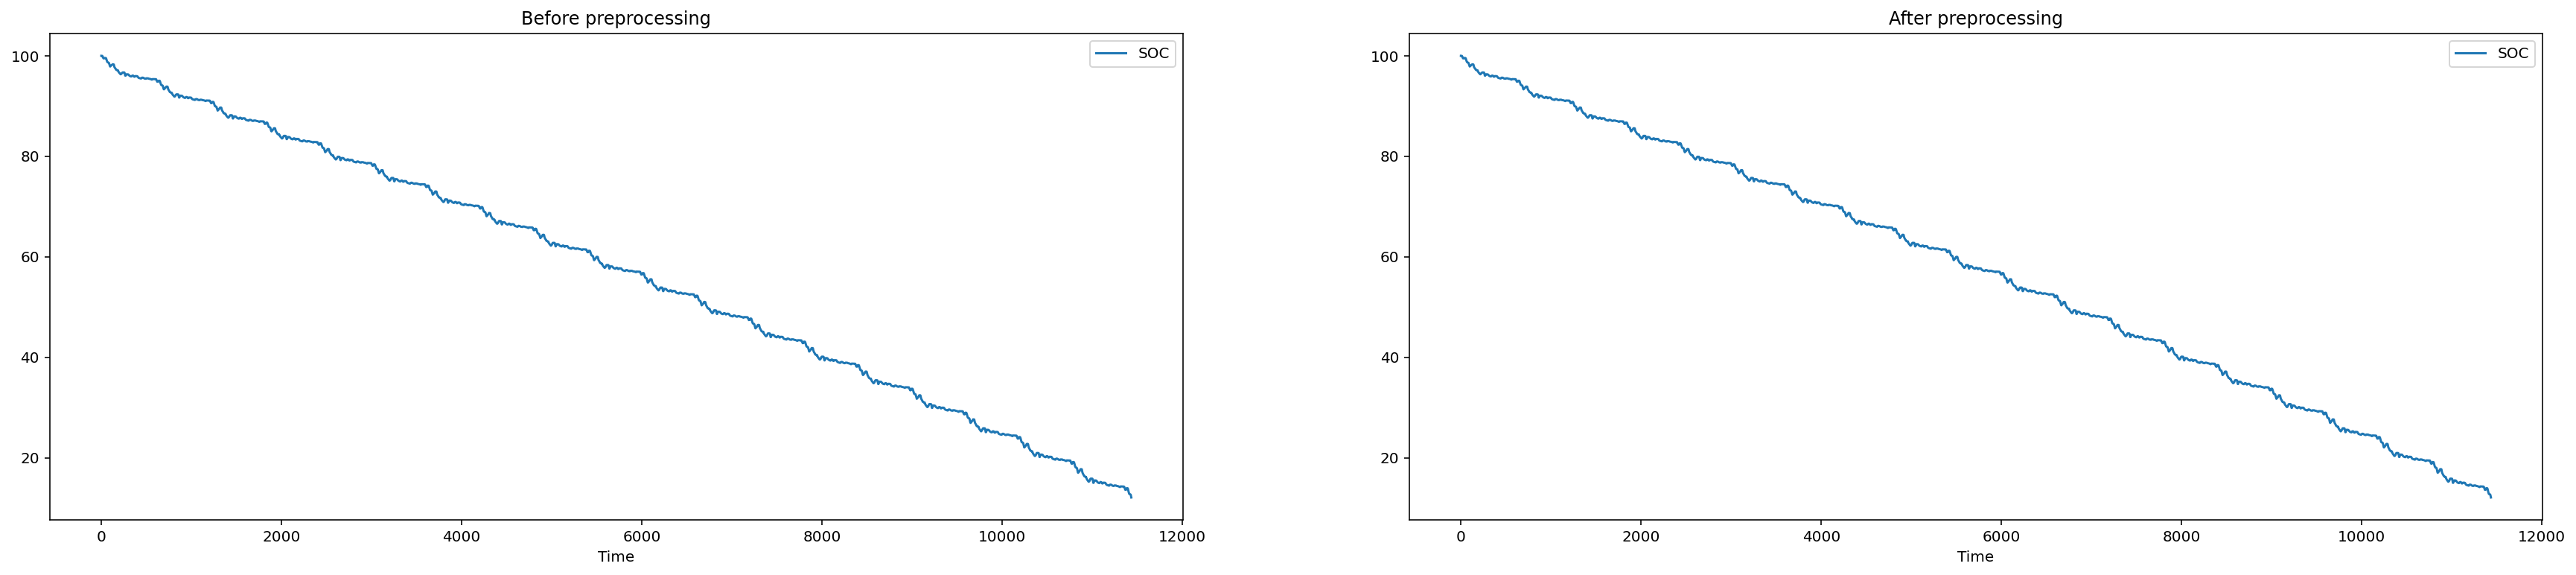

Read from p25degC_Cycle_1_Pan18650PF.csv
Start from 0
Save to p25degC_Cycle_1_Pan18650PF.pickle


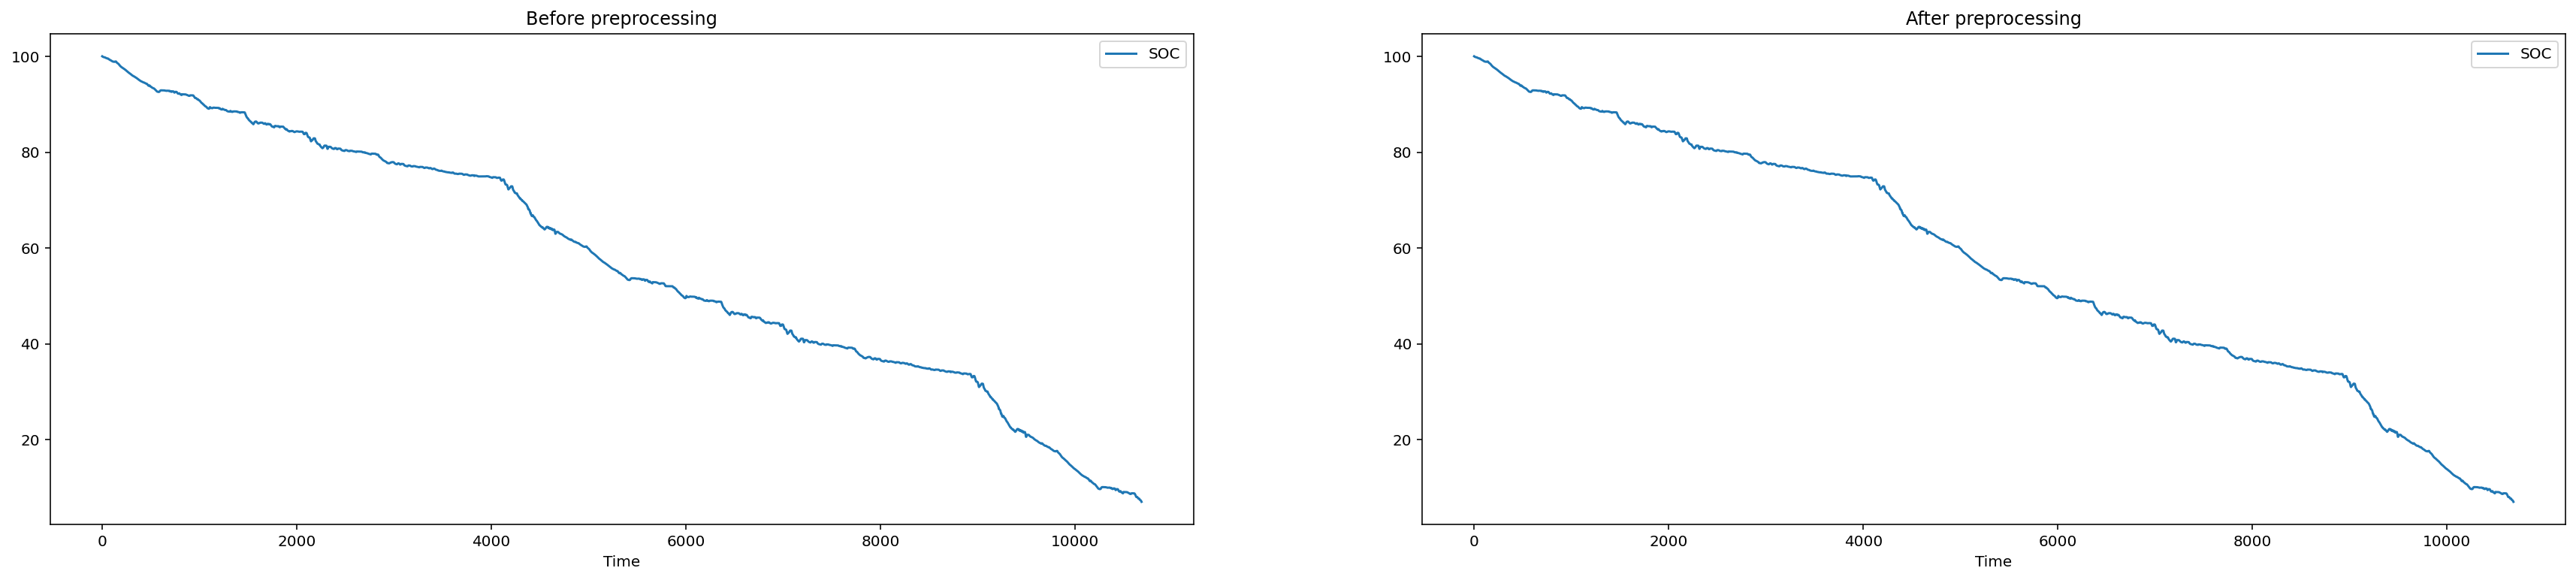

Read from p10degC_Cycle_1_Pan18650PF.csv
Start from 0
Save to p10degC_Cycle_1_Pan18650PF.pickle


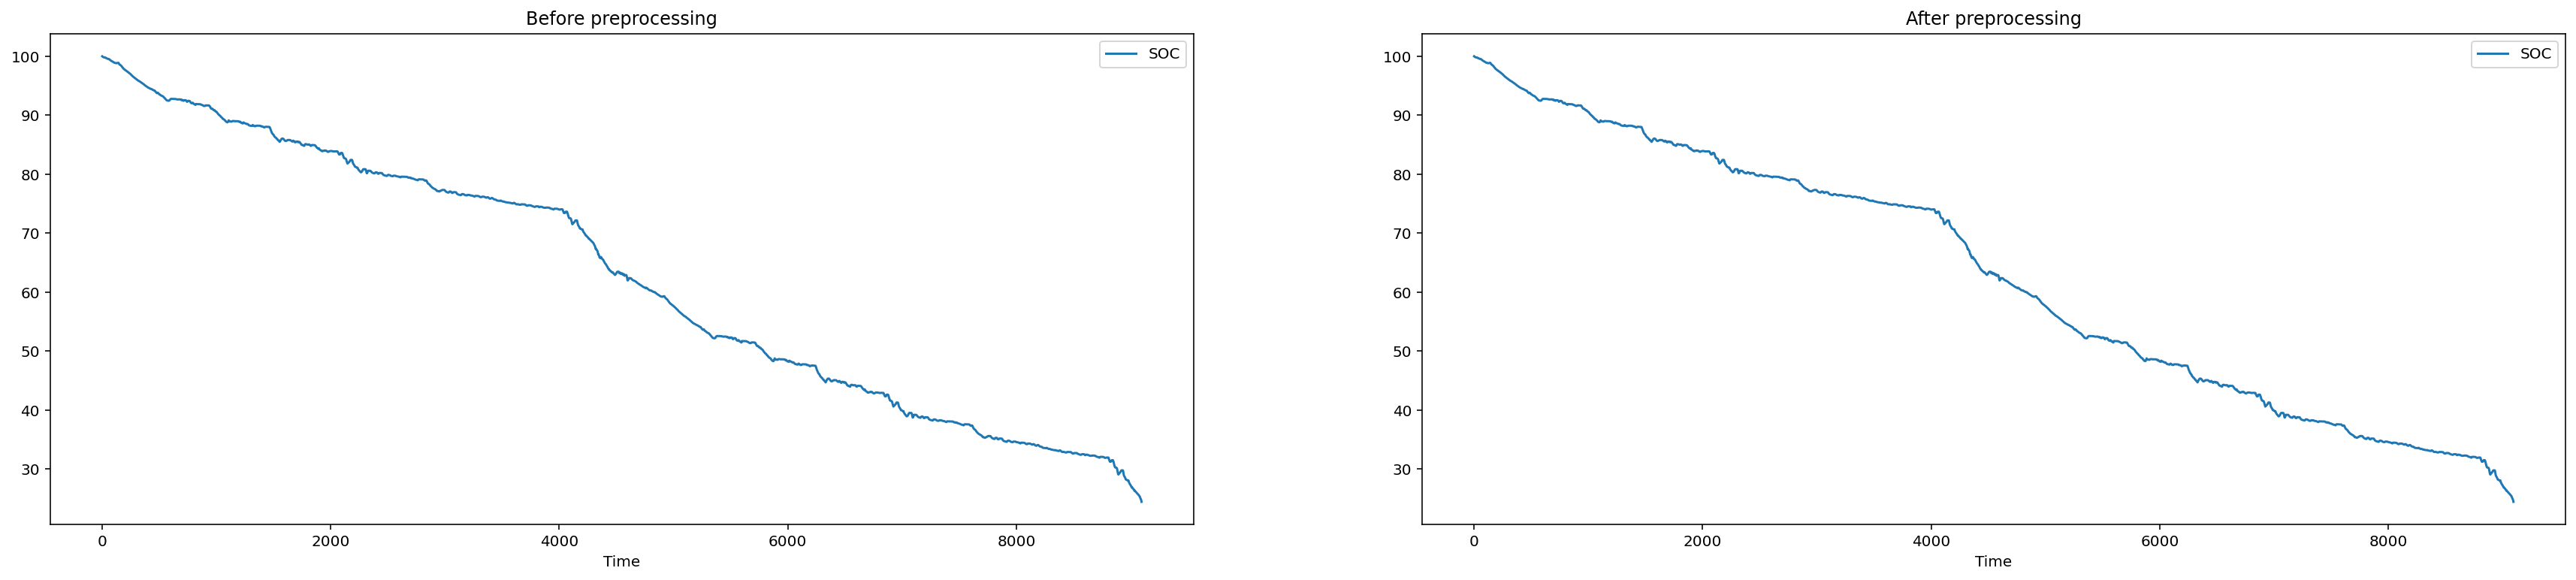

Read from p0degC_NN_Pan18650PF.csv
Start from 121
Save to p0degC_NN_Pan18650PF.pickle


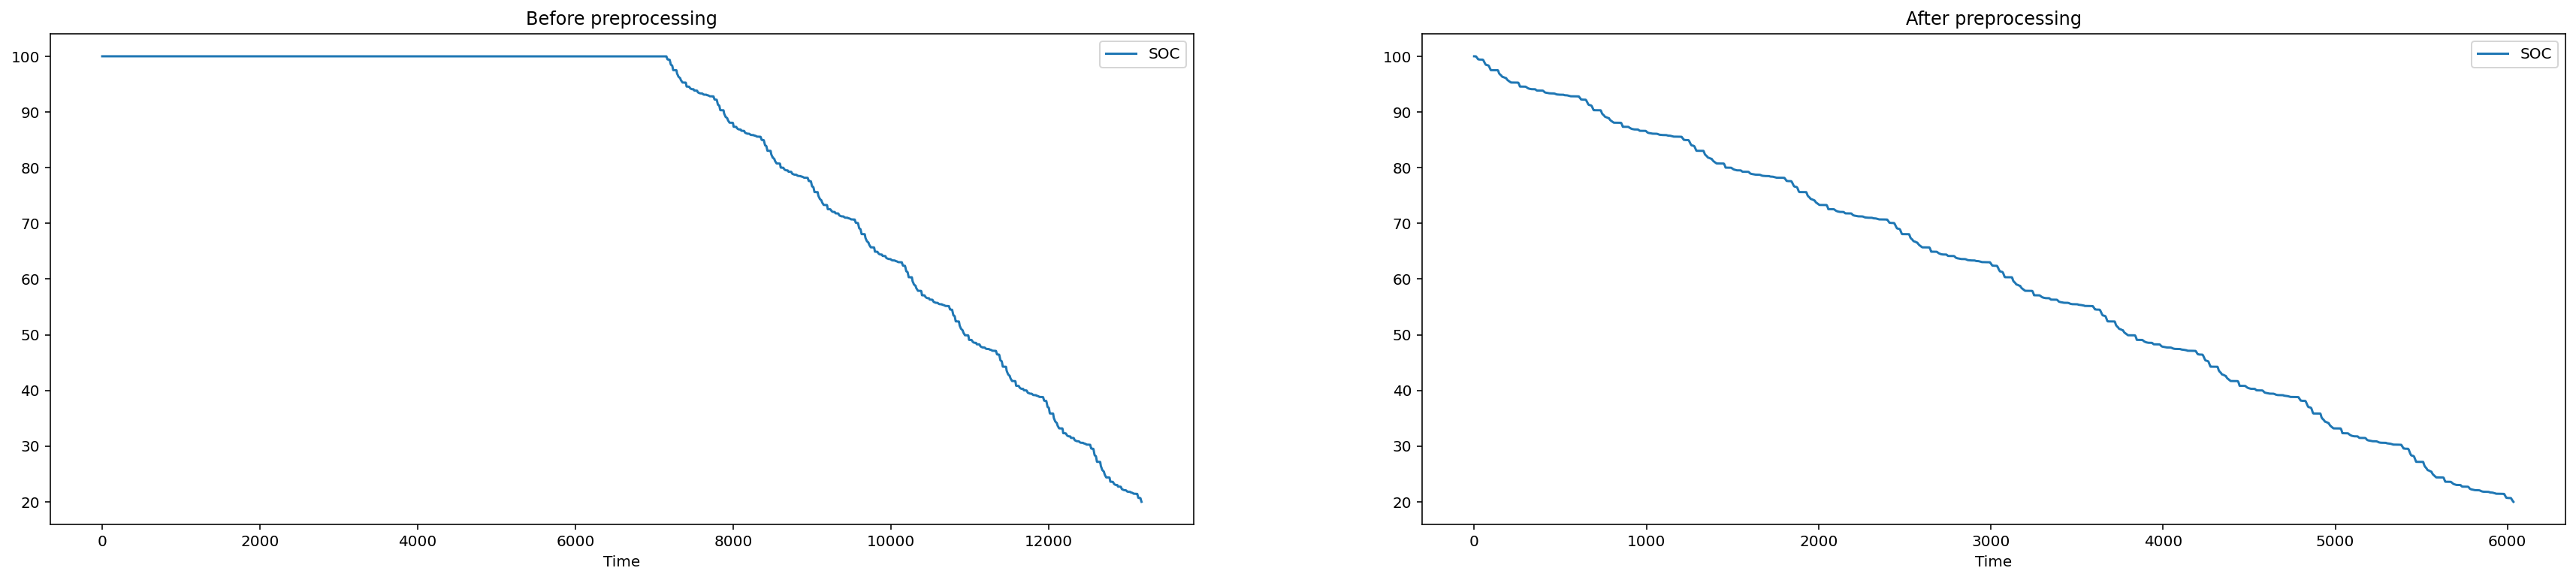

Read from n20degC_US06_Pan18650PF.csv
Start from 0
Save to n20degC_US06_Pan18650PF.pickle


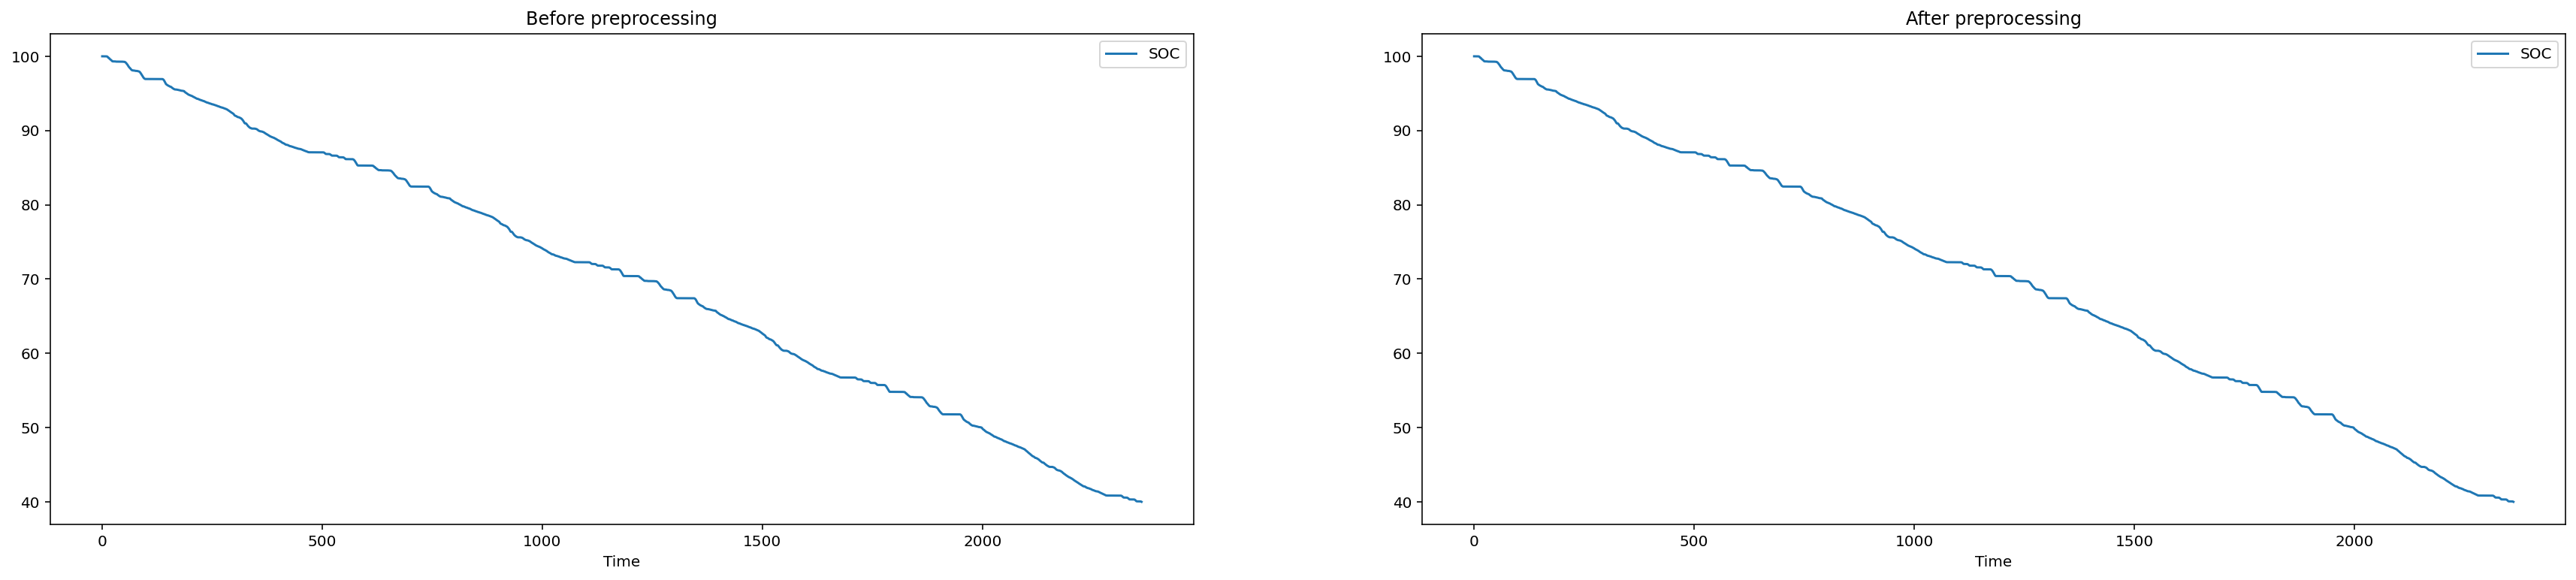

Read from p0degC_Cycle_1_Pan18650PF.csv
Start from 0
Save to p0degC_Cycle_1_Pan18650PF.pickle


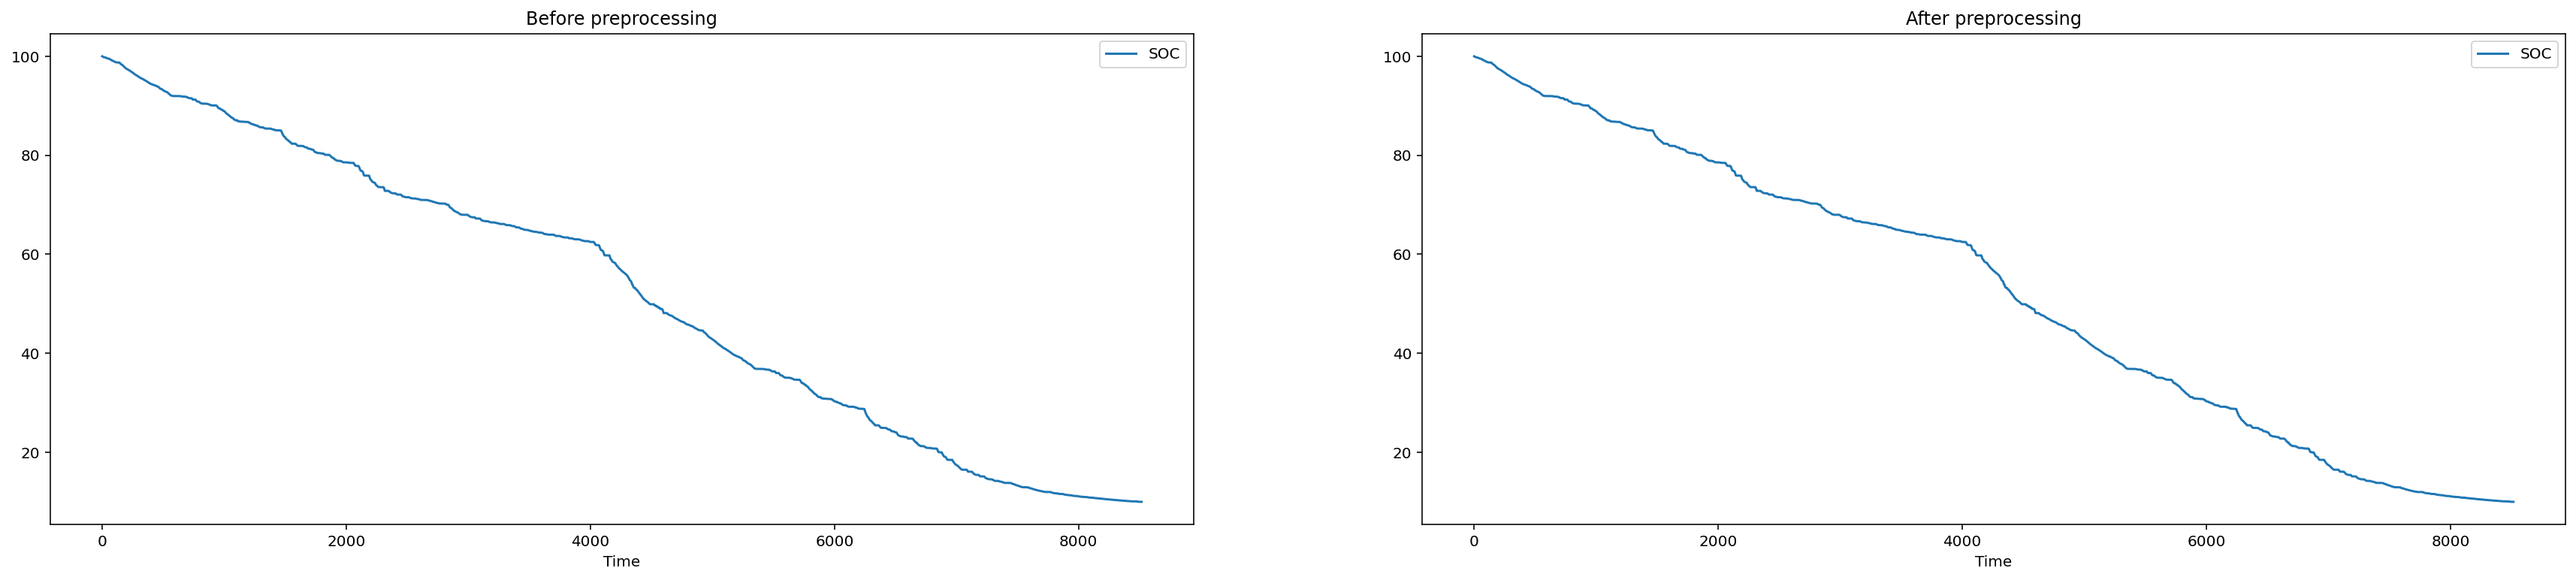

Read from p10degC_US06_Pan18650PF.csv
Start from 0
Save to p10degC_US06_Pan18650PF.pickle


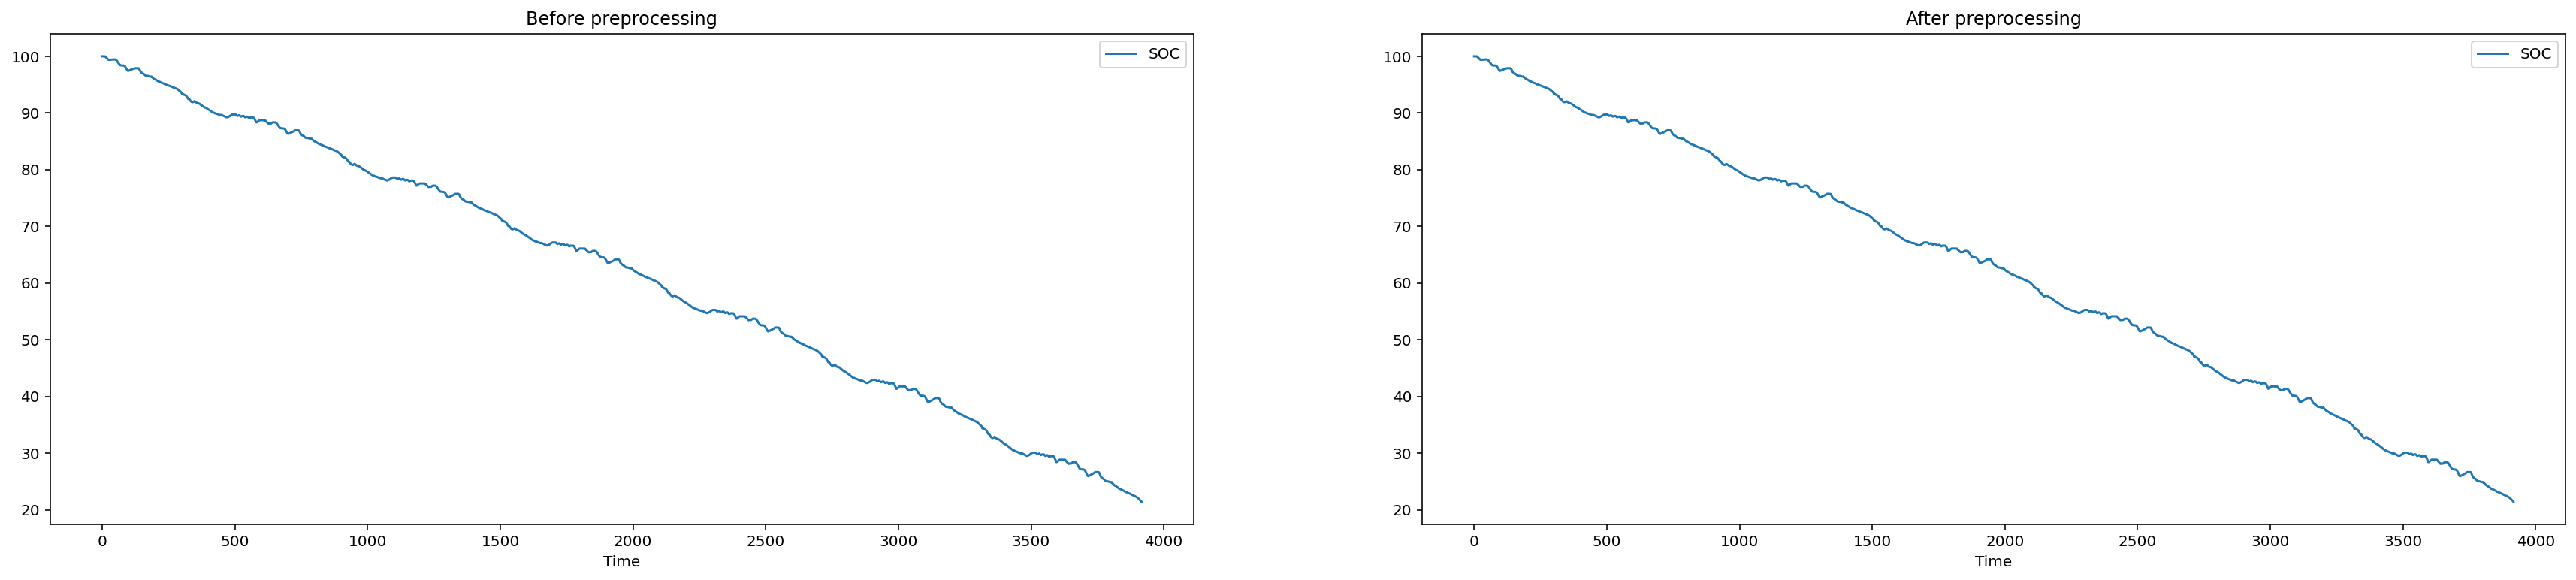

Read from p25degC_US06_Pan18650PF.csv
Start from 0
Save to p25degC_US06_Pan18650PF.pickle


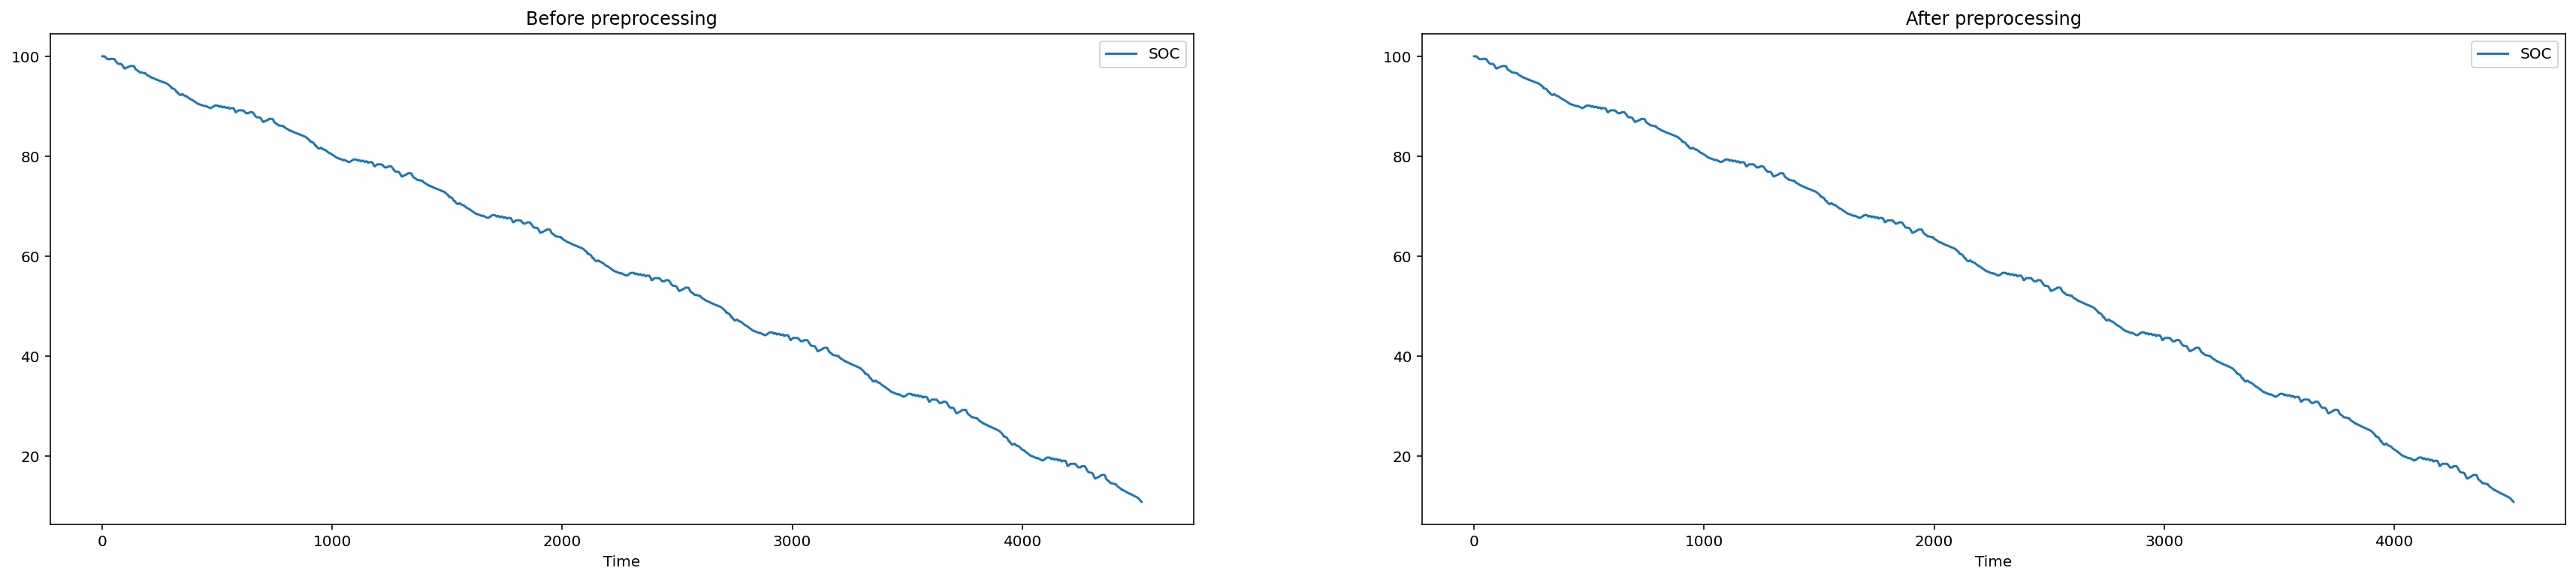

Read from p0degC_US06_Pan18650PF.csv
Start from 0
Save to p0degC_US06_Pan18650PF.pickle


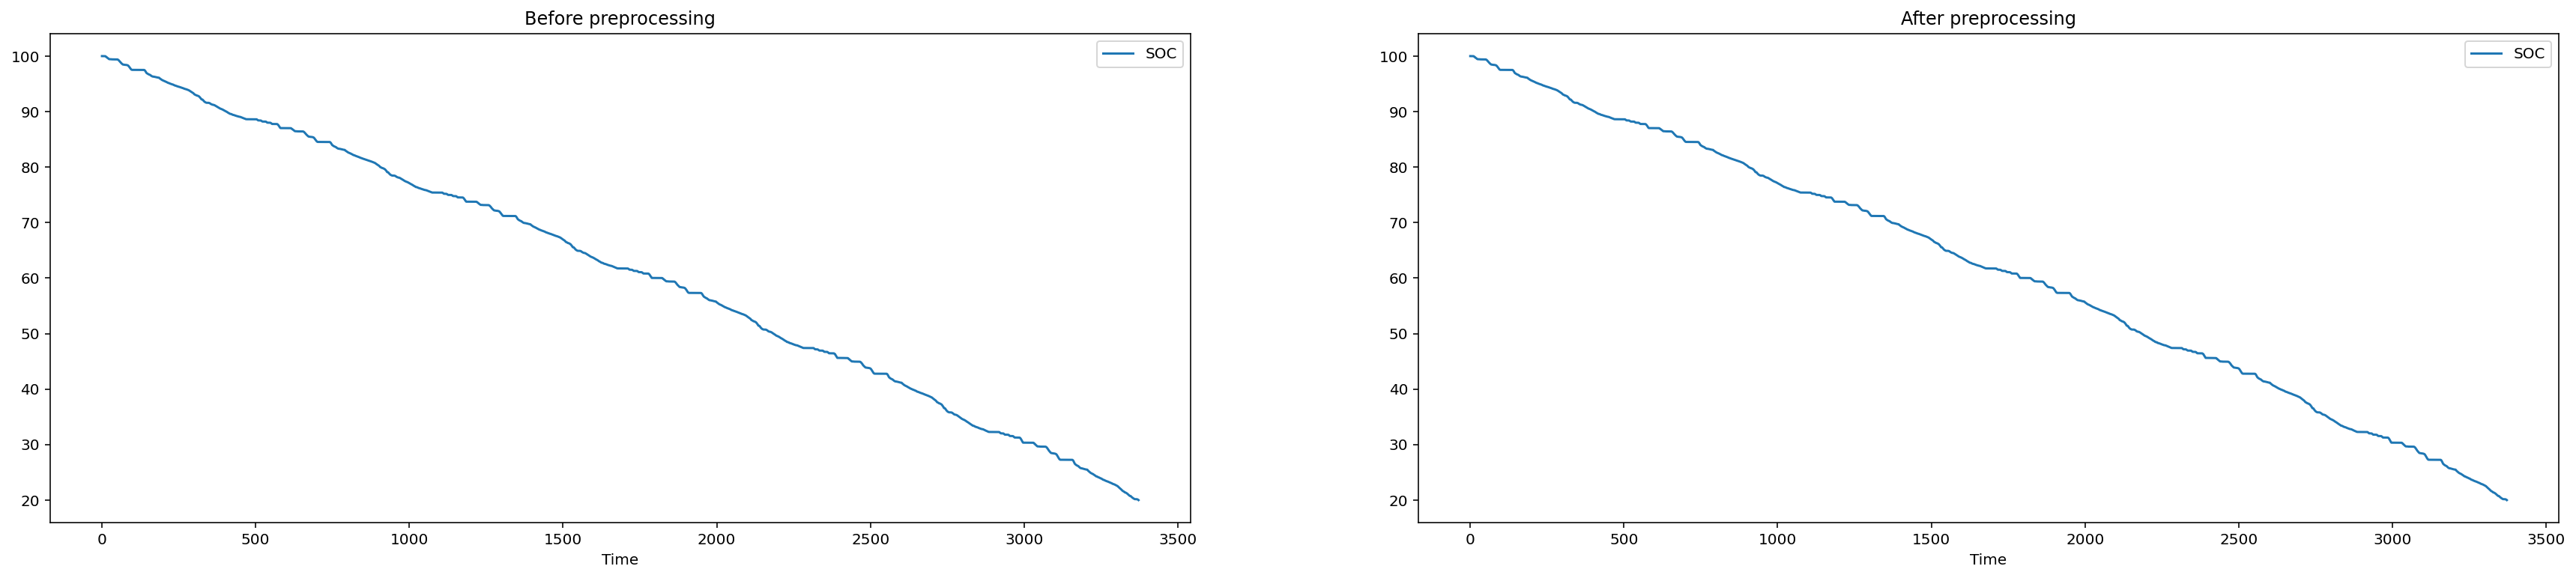

Read from n20degC_NN_Pan18650PF.csv
Start from 121
Save to n20degC_NN_Pan18650PF.pickle


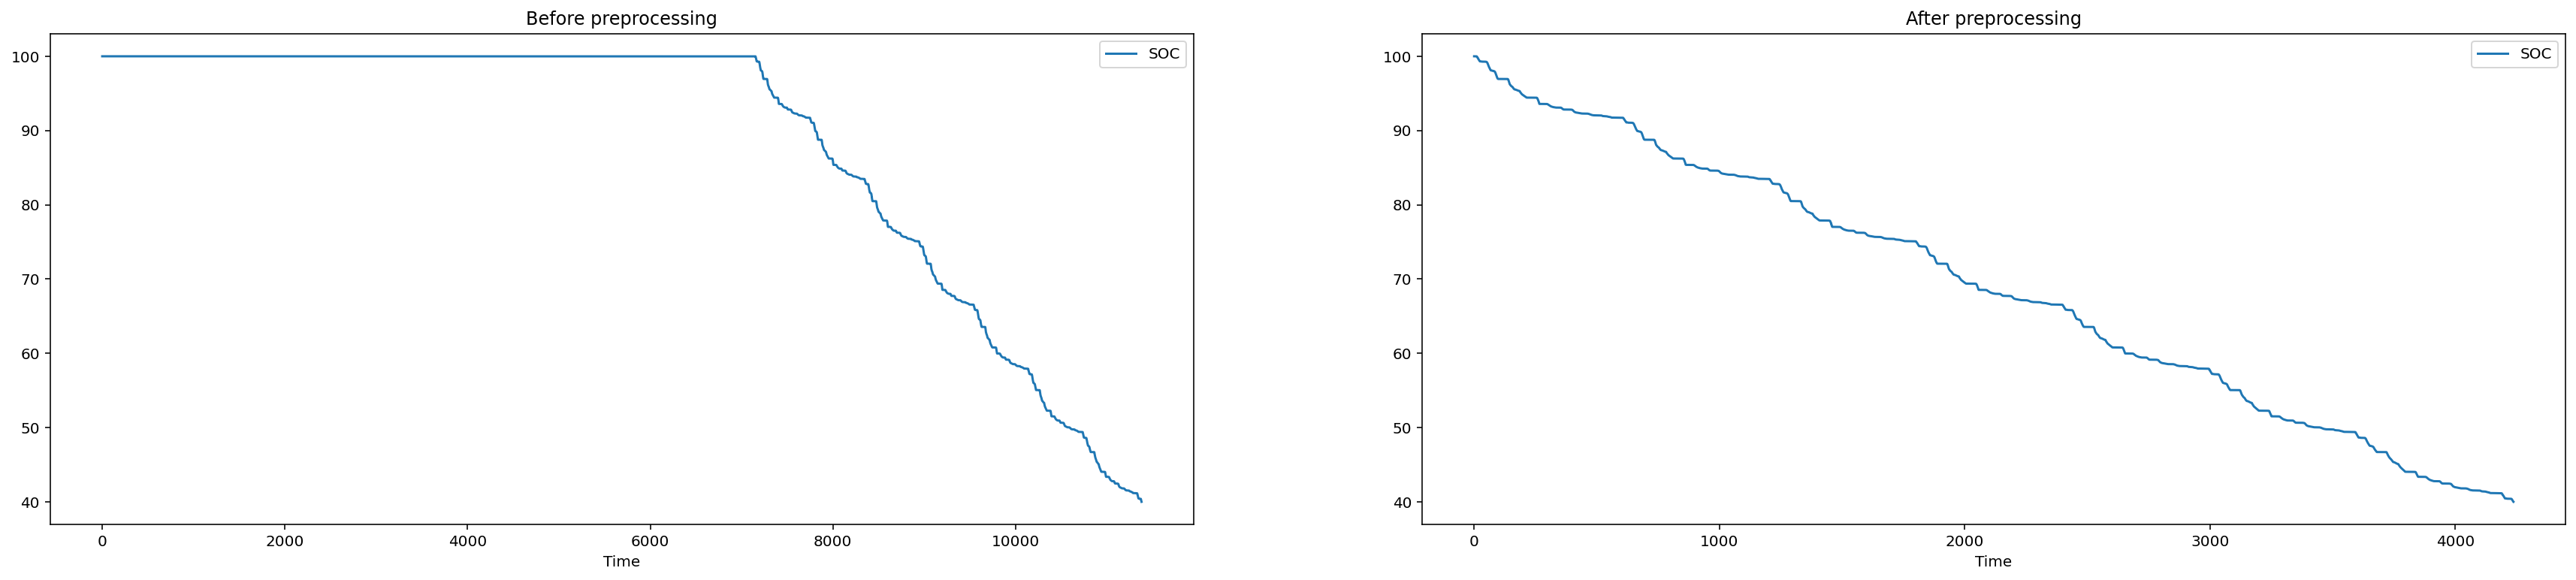

Read from p10degC_NN_Pan18650PF.csv
Start from 61
Save to p10degC_NN_Pan18650PF.pickle


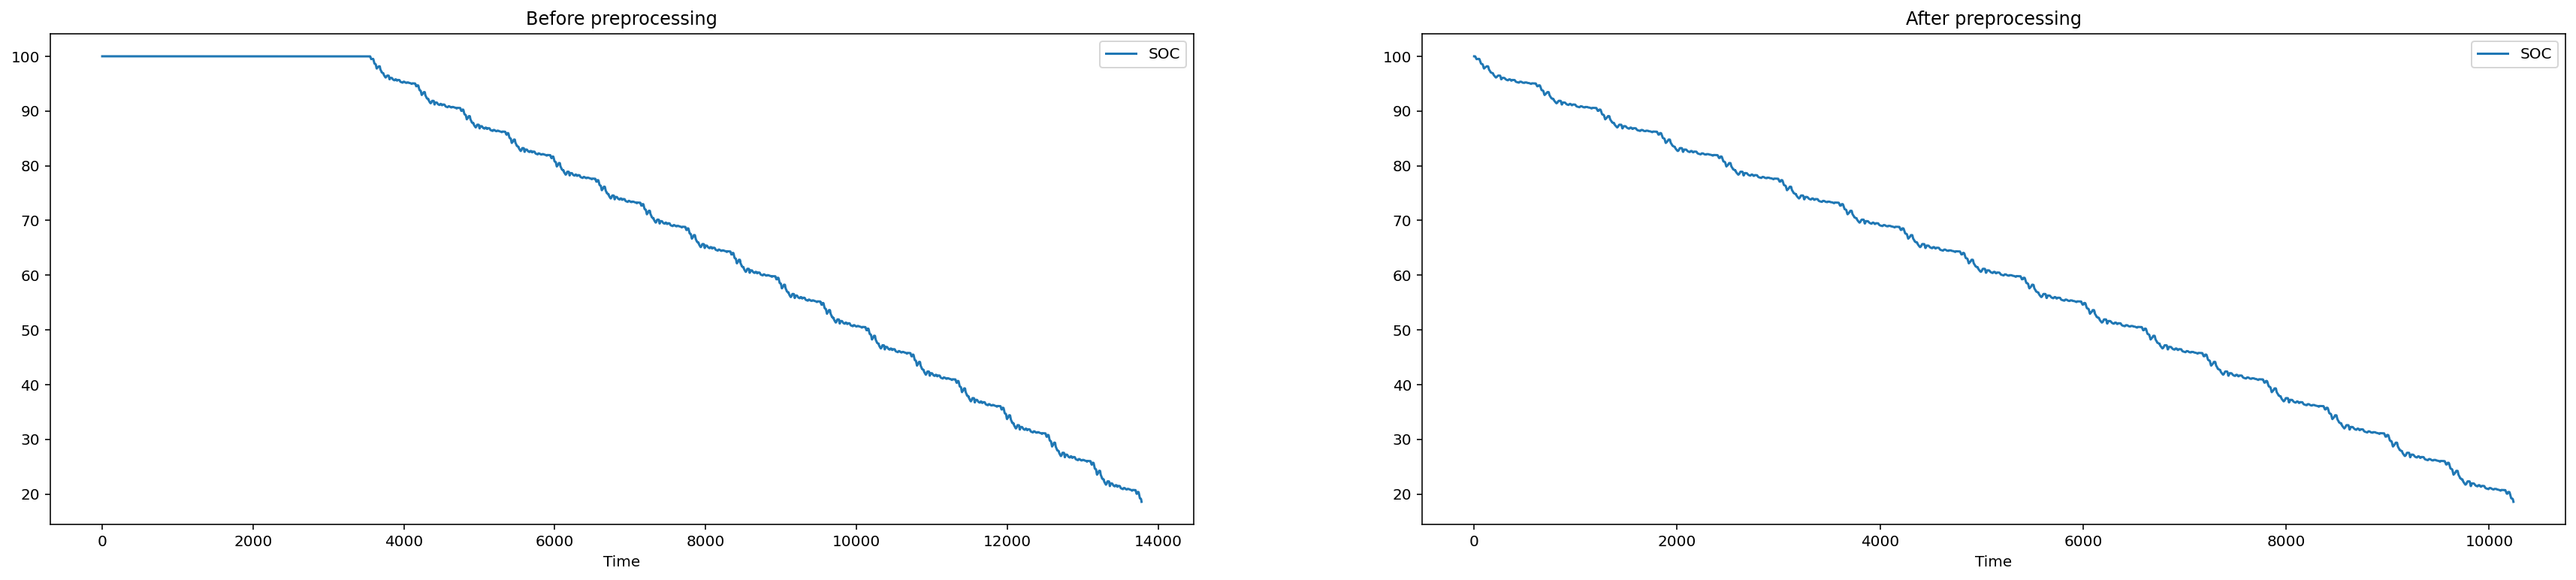

Read from n10degC_Cycle_1_Pan18650PF.csv
Start from 0
Save to n10degC_Cycle_1_Pan18650PF.pickle


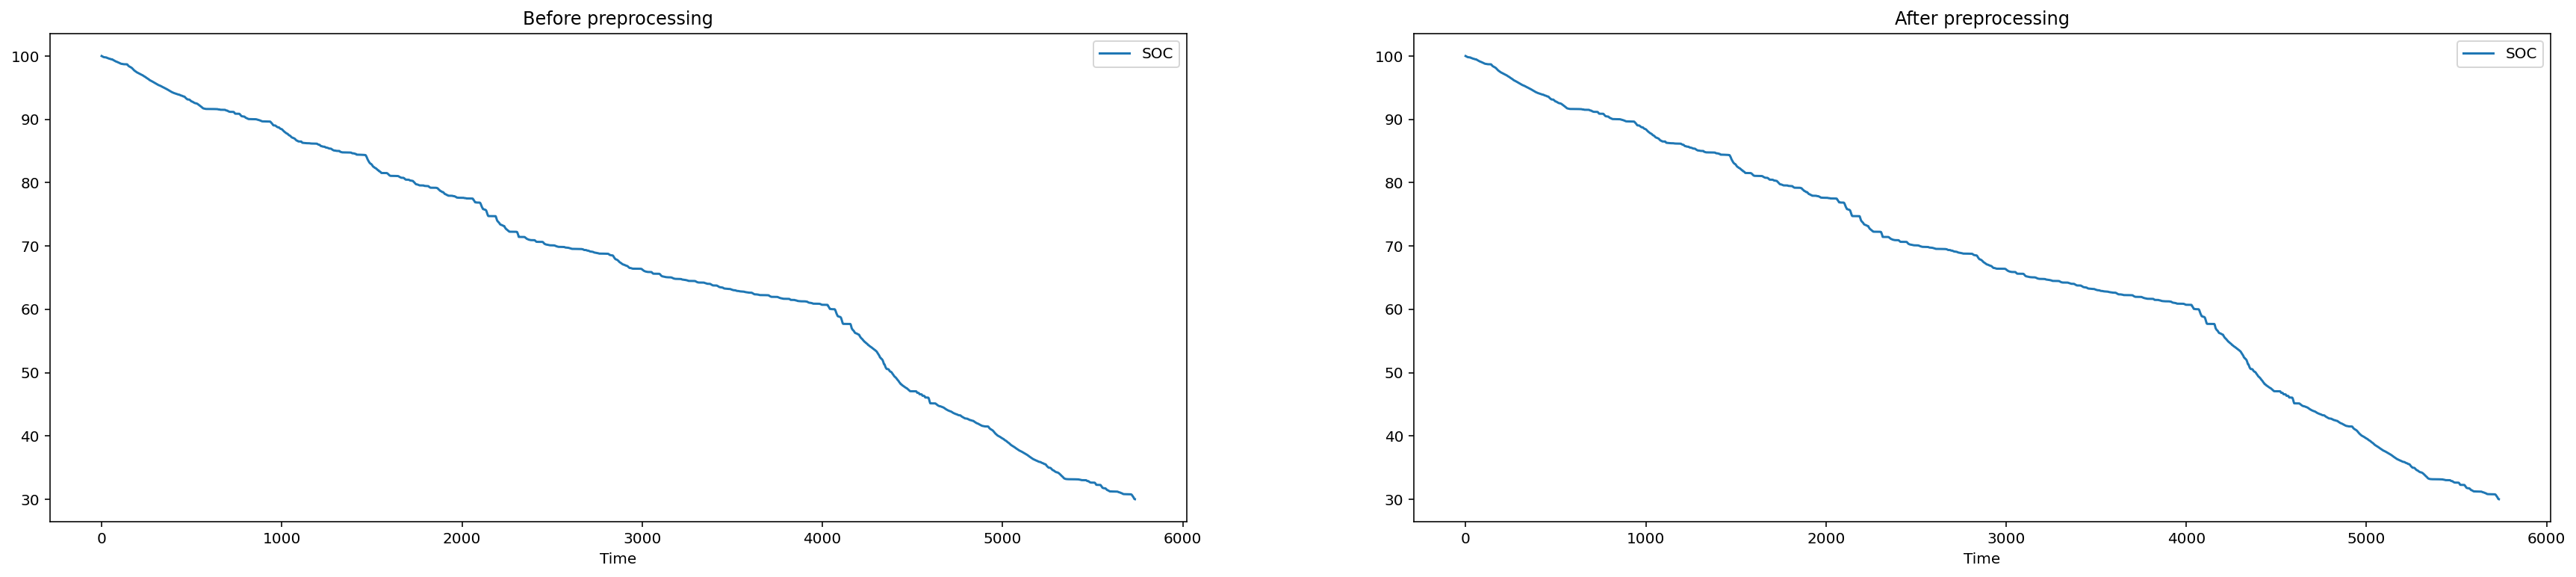

Read from n10degC_US06_Pan18650PF.csv
Start from 121
Save to n10degC_US06_Pan18650PF.pickle


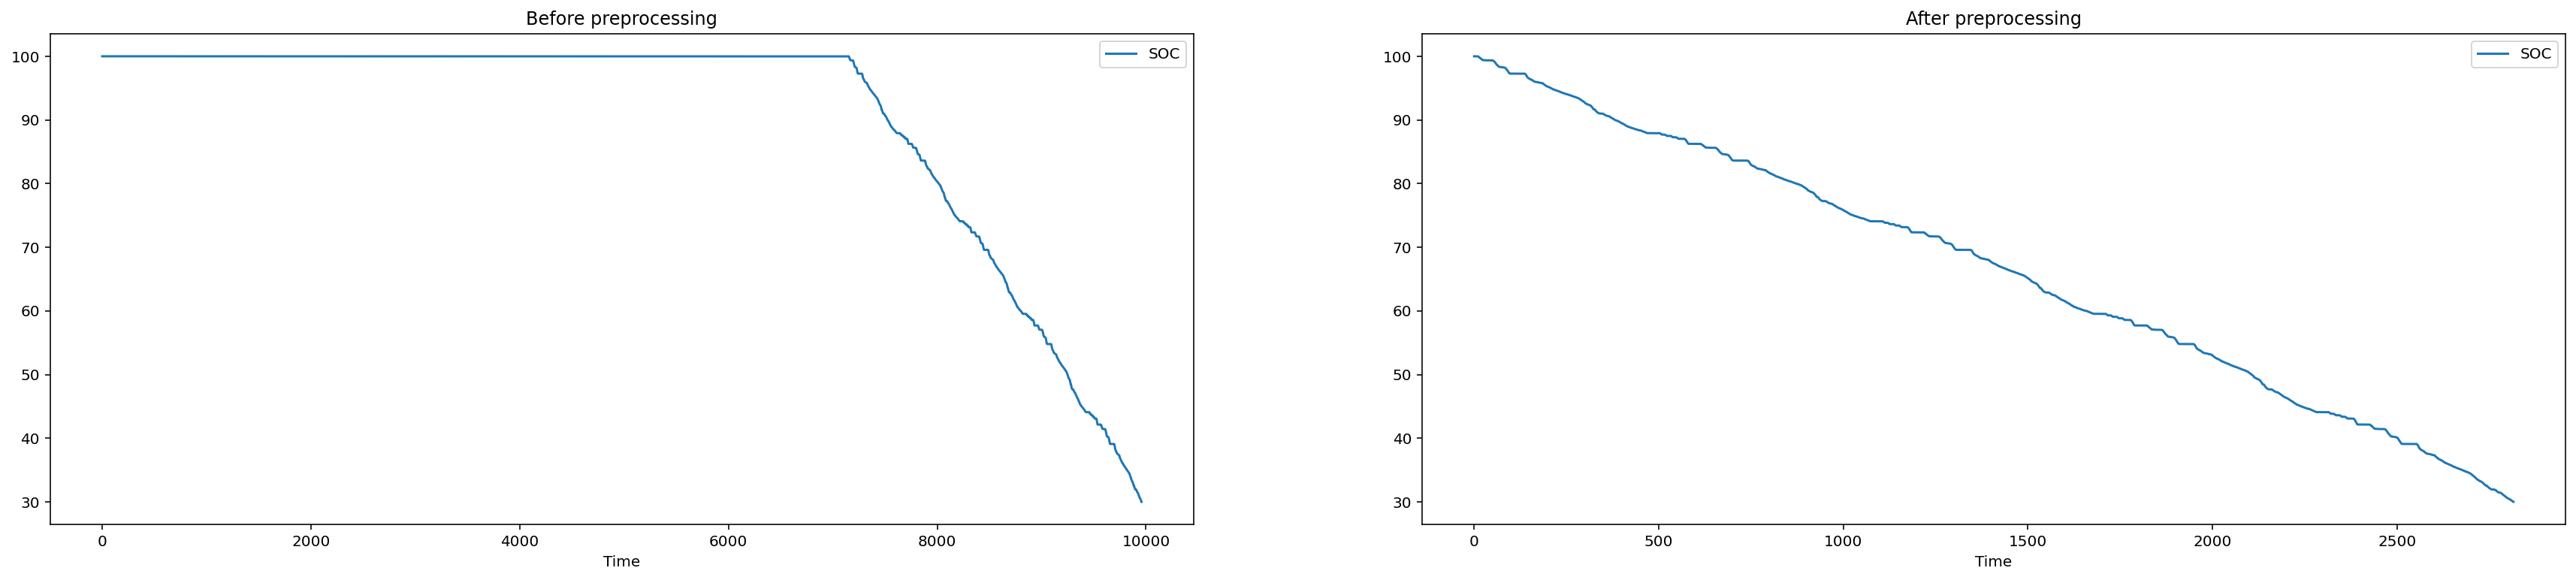

Read from n10degC_NN_Pan18650PF.csv
Start from 0
Save to n10degC_NN_Pan18650PF.pickle


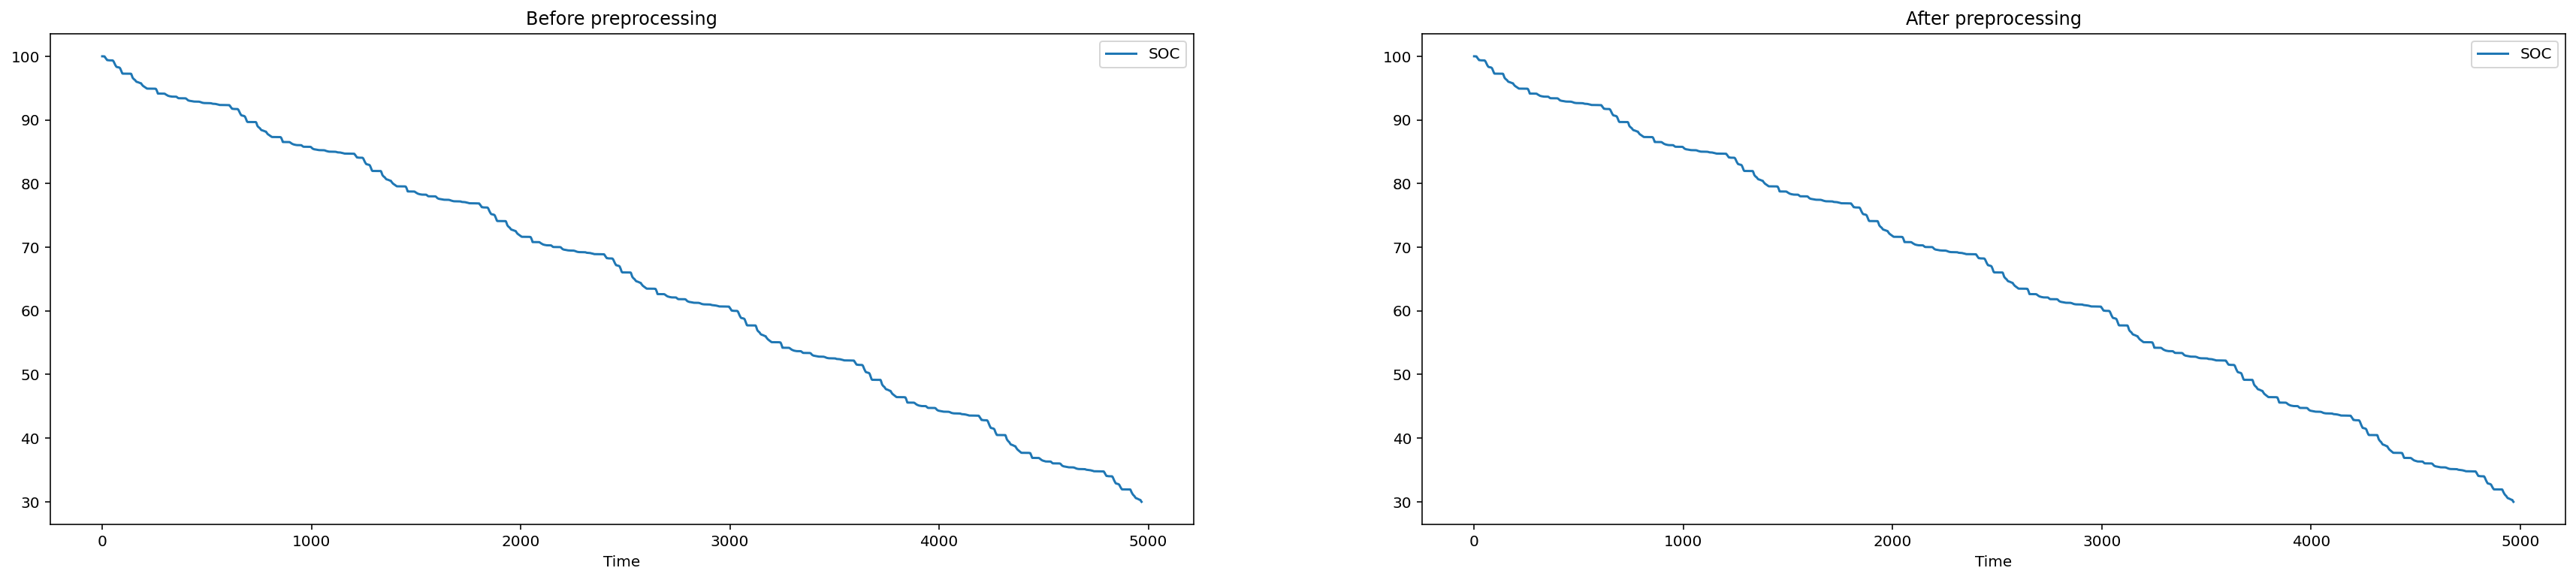

In [3]:
train_files = ROOT_DIR.glob("input/train/*.csv")
for train_file in train_files:
    df = pd.read_csv(train_file)
    print(f"Read from {train_file.name}")
    fig, ax = plt.subplots(ncols=2, figsize=(30, 6))
    df.plot(x="Time", y="SOC", ax=ax[0])
    ax[0].set_title("Before preprocessing")
    
    # Currentが増加したタイミングを、実験開始の (SOCが減り始める) タイミングと判定
    exp_start_idx = df.query("Current != 0.0").index[0]
    print(f"Start from {exp_start_idx}")
    df = df.iloc[exp_start_idx:]
    df.reset_index(drop=True, inplace=True)
    df.loc[:, "Time"] = df["Time"] - df["Time"].iloc[0]  # Time (経過時間) を振り直す
    df.plot(x="Time", y="SOC", ax=ax[1])
    ax[1].set_title("After preprocessing")
    save_file_name = OUT_DIR.joinpath("train", train_file.name).with_suffix(".pickle")
    
    # Currentが増加するまでの部分を除去して保存する
    print(f"Save to {save_file_name.name}")
    df.to_pickle(save_file_name)
    plt.show()

## 2. テストデータの前処理

In [4]:
test_df = pd.read_csv(ROOT_DIR.joinpath("input", "test.csv"))
test_df.head()

ID             TimeStamp  Voltage  Current     Power  Battery_Temp_degC  \
0   0  6/24/2017 7:29:56 PM  4.11690 -1.50911 -6.212855         -20.308876   
1   1  6/24/2017 7:29:56 PM  3.99144 -1.60057 -6.388579         -20.308876   
2   2  6/24/2017 7:29:56 PM  3.90330 -1.66182 -6.486582         -20.308876   
3   3  6/24/2017 7:29:56 PM  3.84861 -1.69694 -6.530860         -20.308876   
4   4  6/24/2017 7:29:56 PM  3.79586 -1.72797 -6.559132         -20.308876   

       Time  Chamber_Temp_degC Drive Cycle  
0  0.000000                -20     Cycle_3  
1  0.104003                -20     Cycle_3  
2  0.202001                -20     Cycle_3  
3  0.299998                -20     Cycle_3  
4  0.399998                -20     Cycle_3

In [5]:
test_df.shape

(2618963, 9)

### 2.1 test.csv を実験ごとのファイルに分割する

In [6]:
start_idxs = test_df.query("Time == 0.0").index.tolist()
start_idxs.append(test_df.index[-1] + 1)
start_idxs

[0,
 47147,
 105249,
 213517,
 260862,
 309249,
 516769,
 576235,
 642845,
 697041,
 822563,
 946139,
 1029362,
 1103414,
 1181510,
 1402697,
 1498684,
 1636558,
 1675888,
 1732600,
 1779975,
 1877771,
 1931628,
 2011297,
 2084252,
 2151683,
 2251124,
 2337529,
 2455392,
 2512246,
 2618963]

In [7]:
for i in range(len(start_idxs) - 1):
    start_idx = start_idxs[i]
    end_idx = start_idxs[i+1]
    
    # Timeが0.0のタイミングで切り離す
    _tmp_df = test_df.iloc[start_idx: end_idx].reset_index(drop=True)
    _drive_cycle = _tmp_df["Drive Cycle"].unique()[0]
    _temp_degc = _tmp_df["Chamber_Temp_degC"].unique()[0]
    
    # 実験ごとに保存する
    file_name = str(_temp_degc) + "_" + _drive_cycle
    _tmp_df.to_csv(ROOT_DIR.joinpath("input", "test", f"{file_name}.csv"))

### 2.2 各実験ファイルを前処理

Read from -20_Cycle_3.csv
Start from 0
Save to -20_Cycle_3.pickle


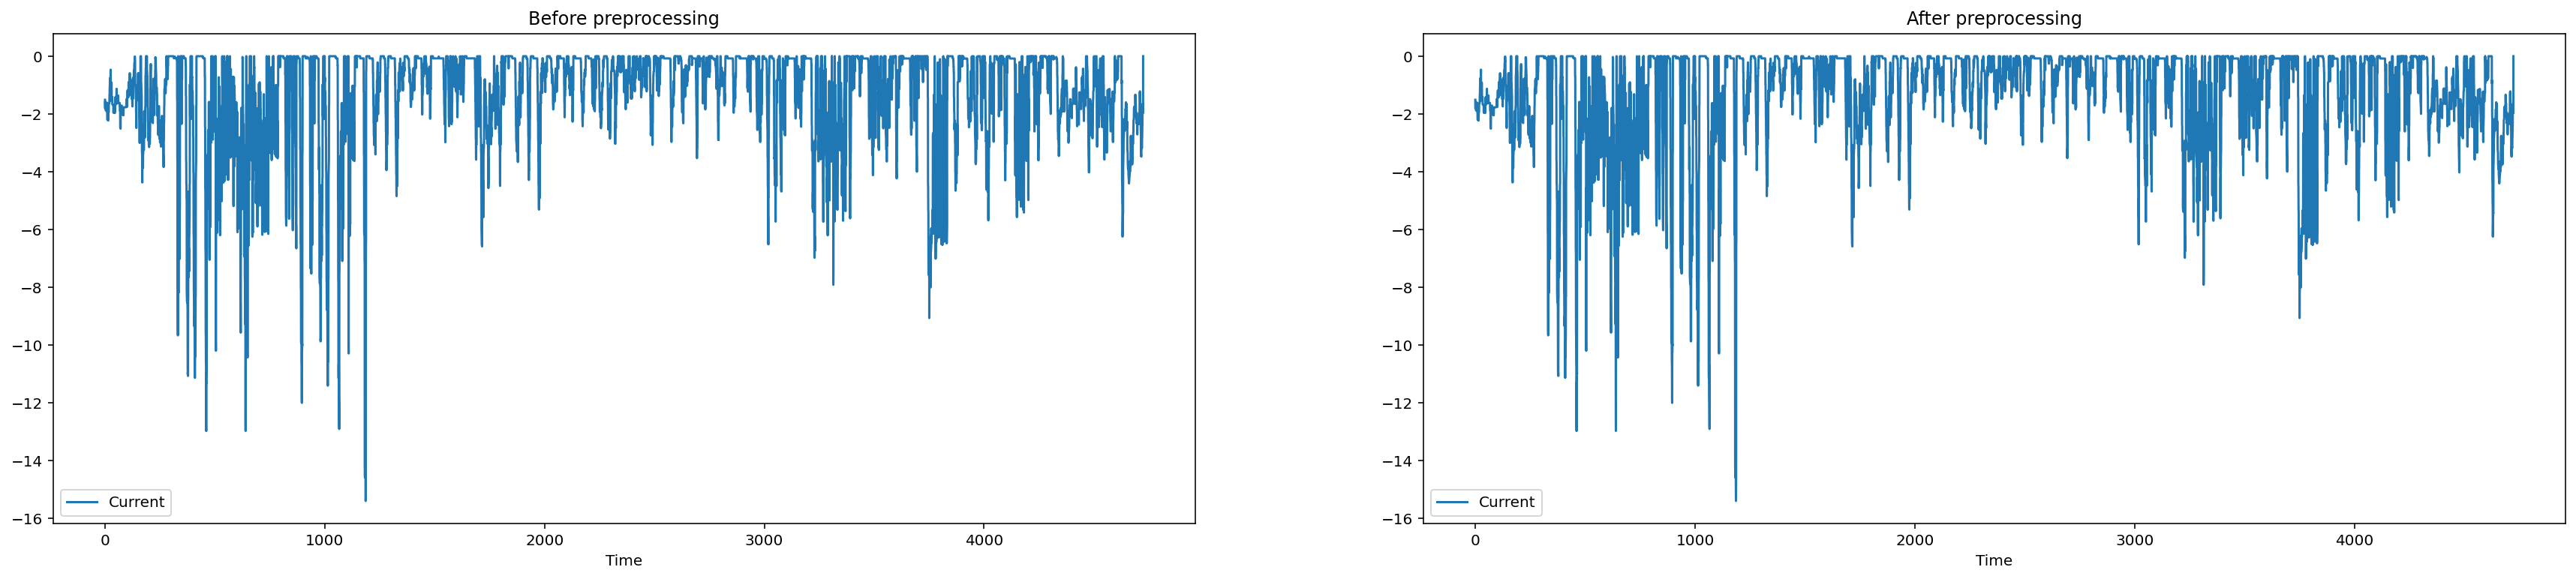

Read from -20_Cycle_2.csv
Start from 0
Save to -20_Cycle_2.pickle


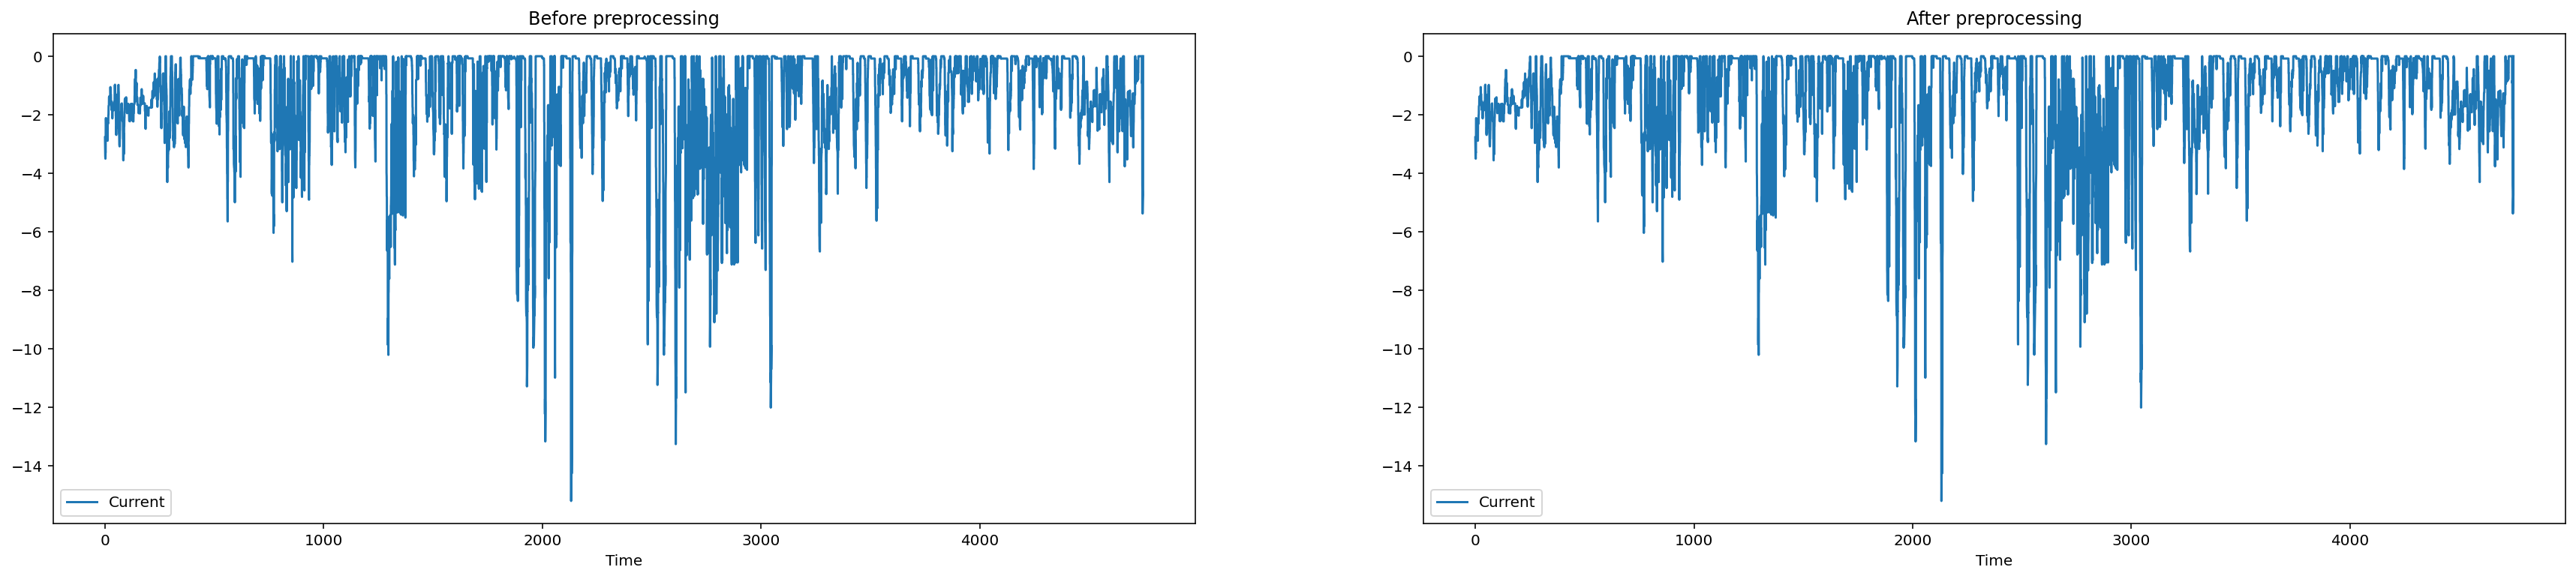

Read from -20_Cycle_4.csv
Start from 0
Save to -20_Cycle_4.pickle


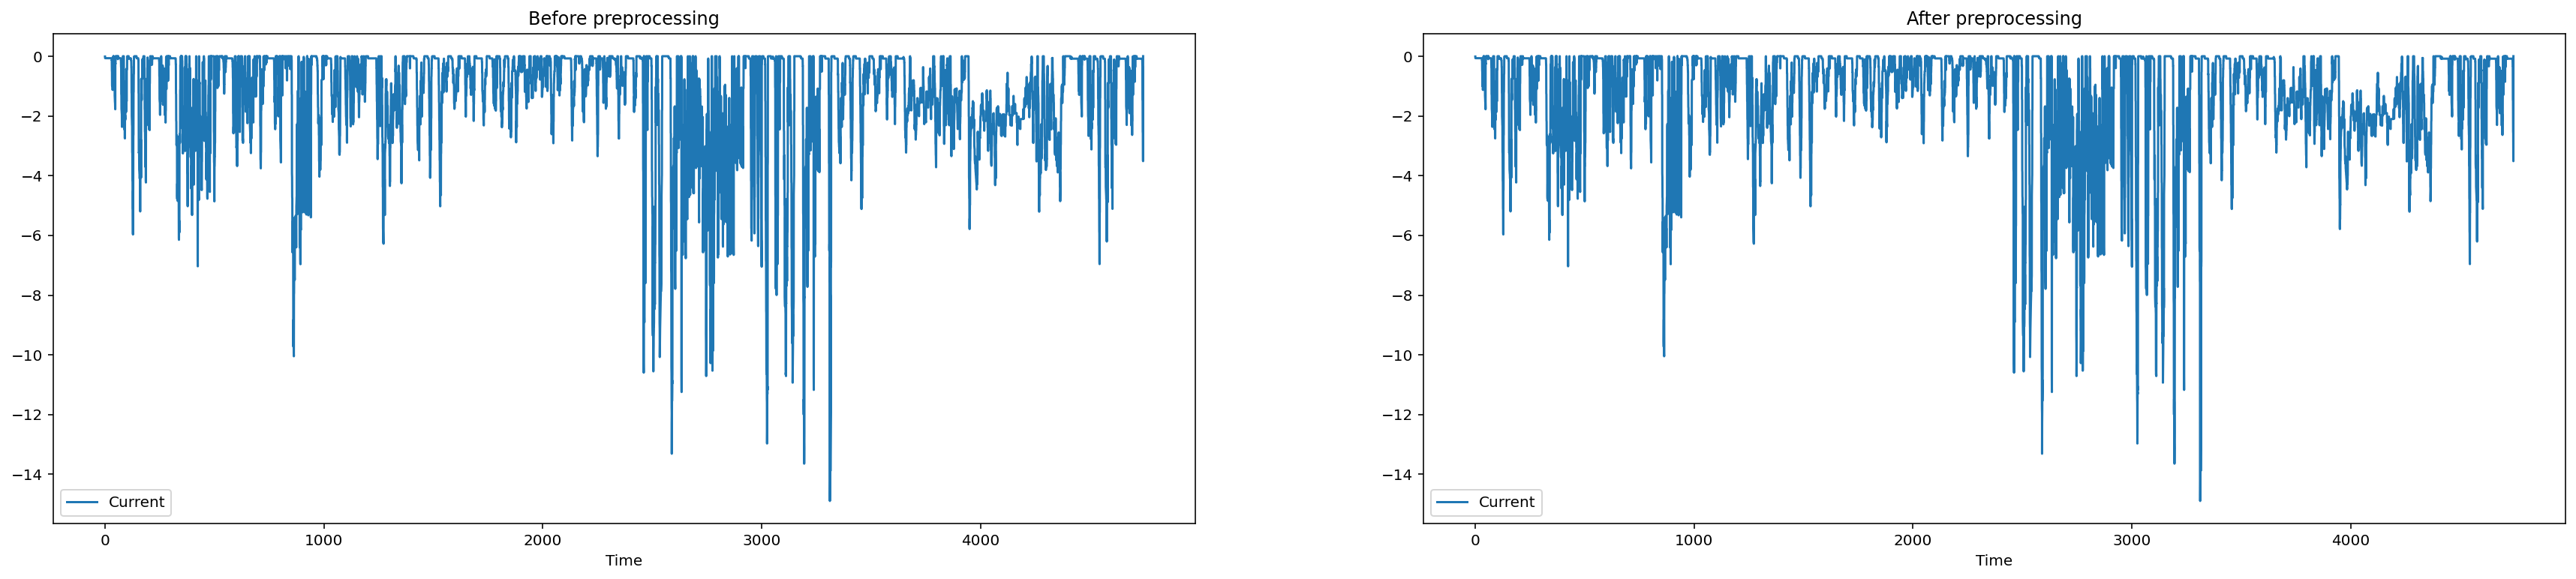

Read from 10_HWFET.csv
Start from 61
Save to 10_HWFET.pickle


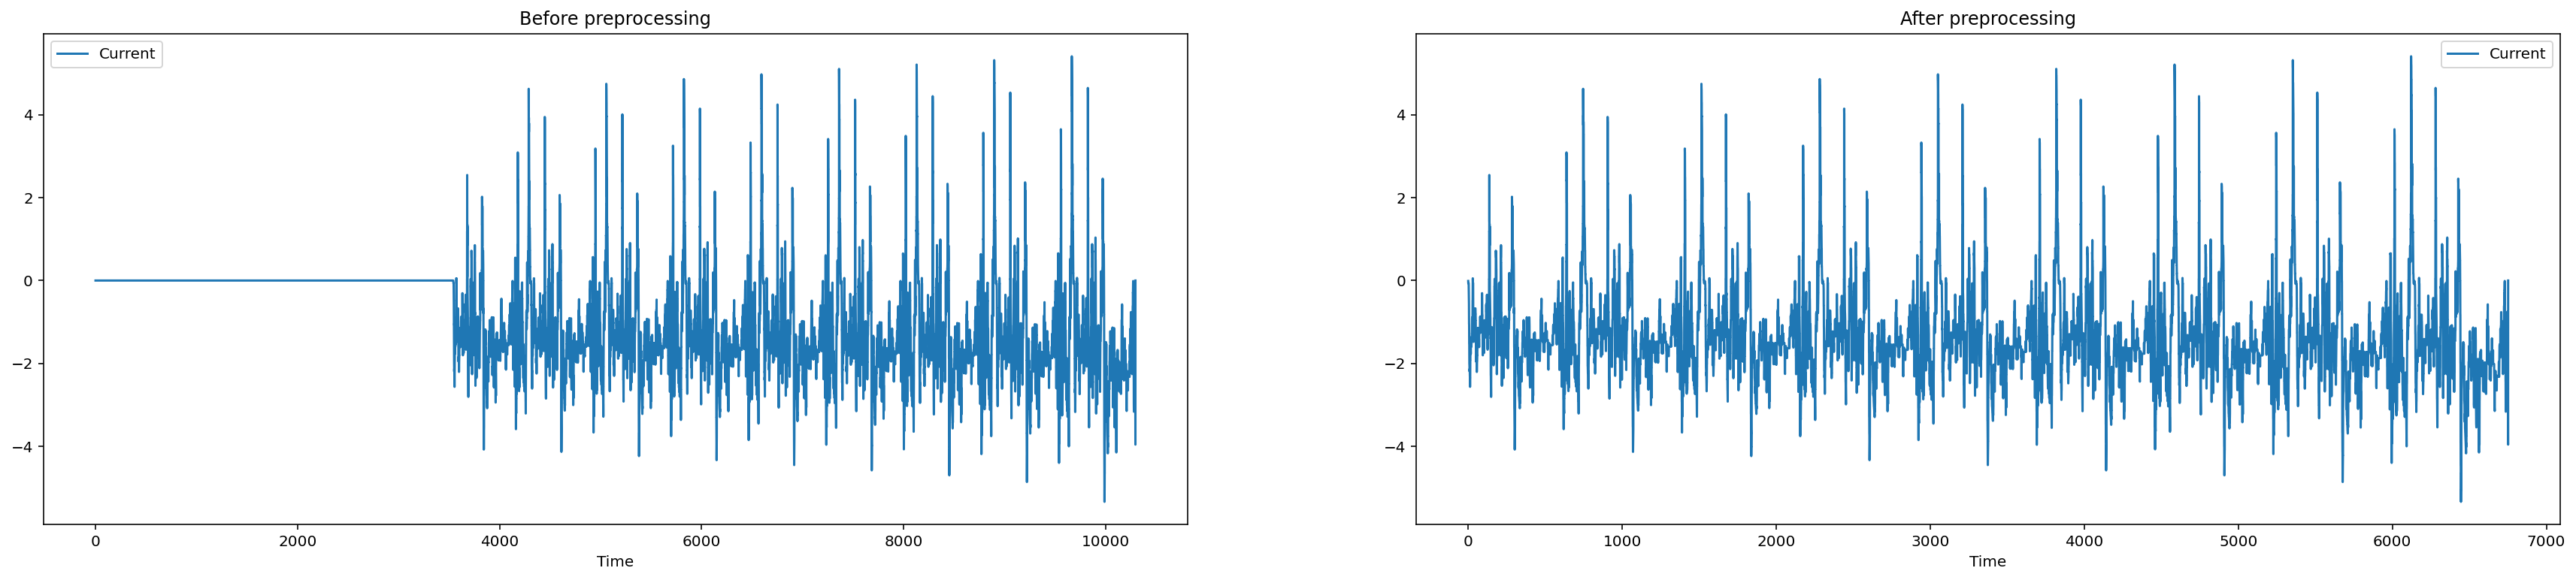

Read from -10_UDDS.csv
Start from 121
Save to -10_UDDS.pickle


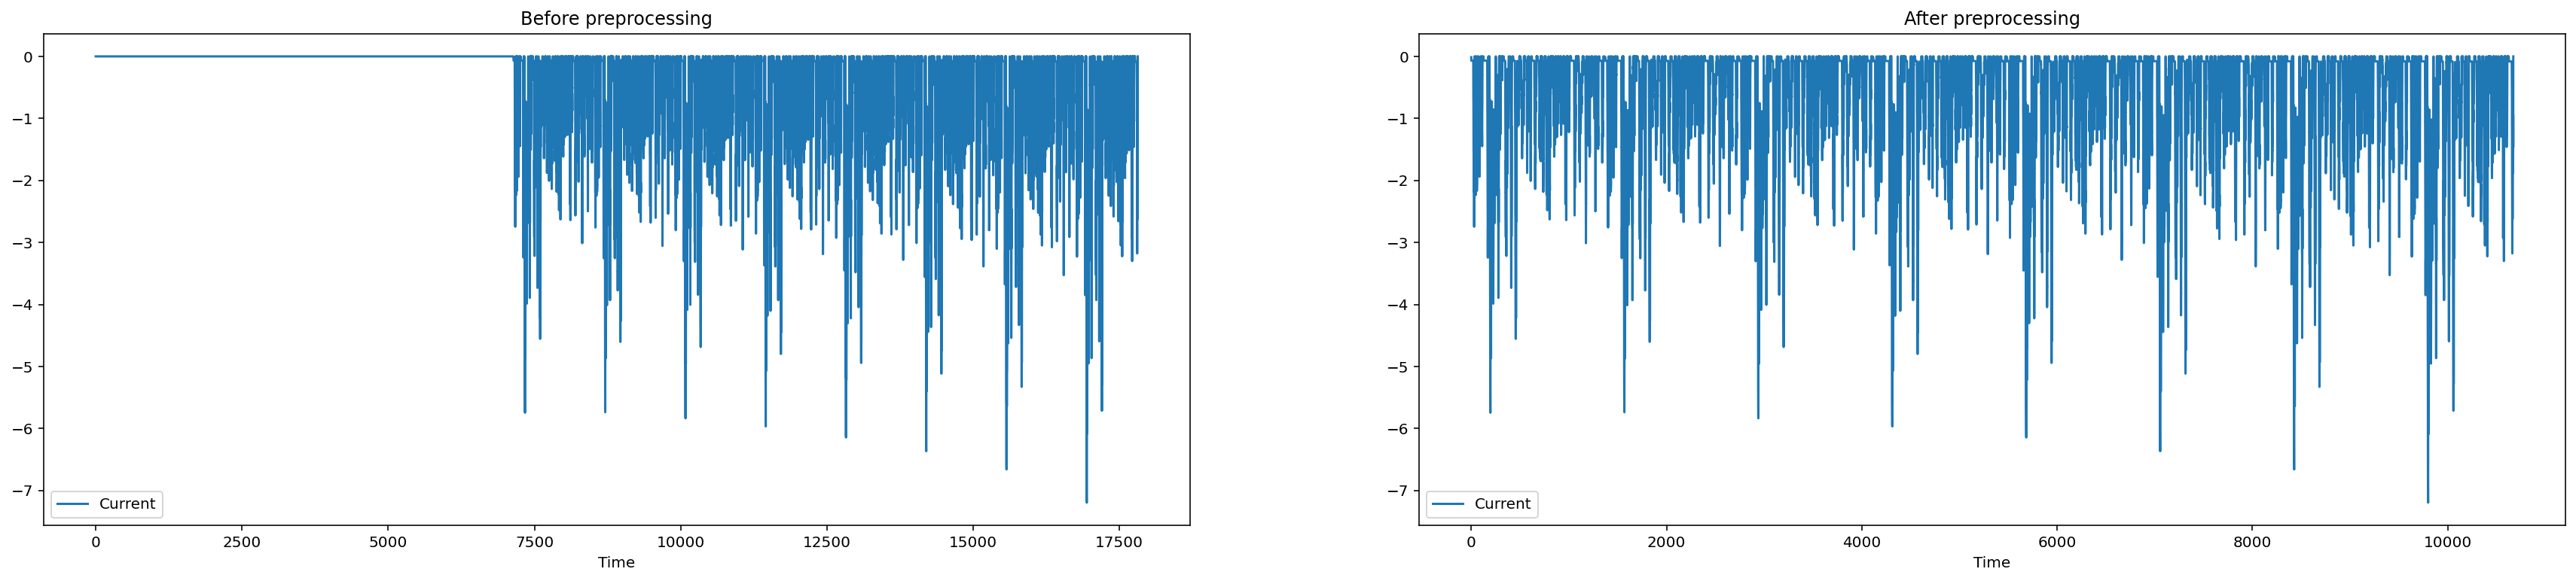

Read from 25_HWFET.csv
Start from 0
Save to 25_HWFET.pickle


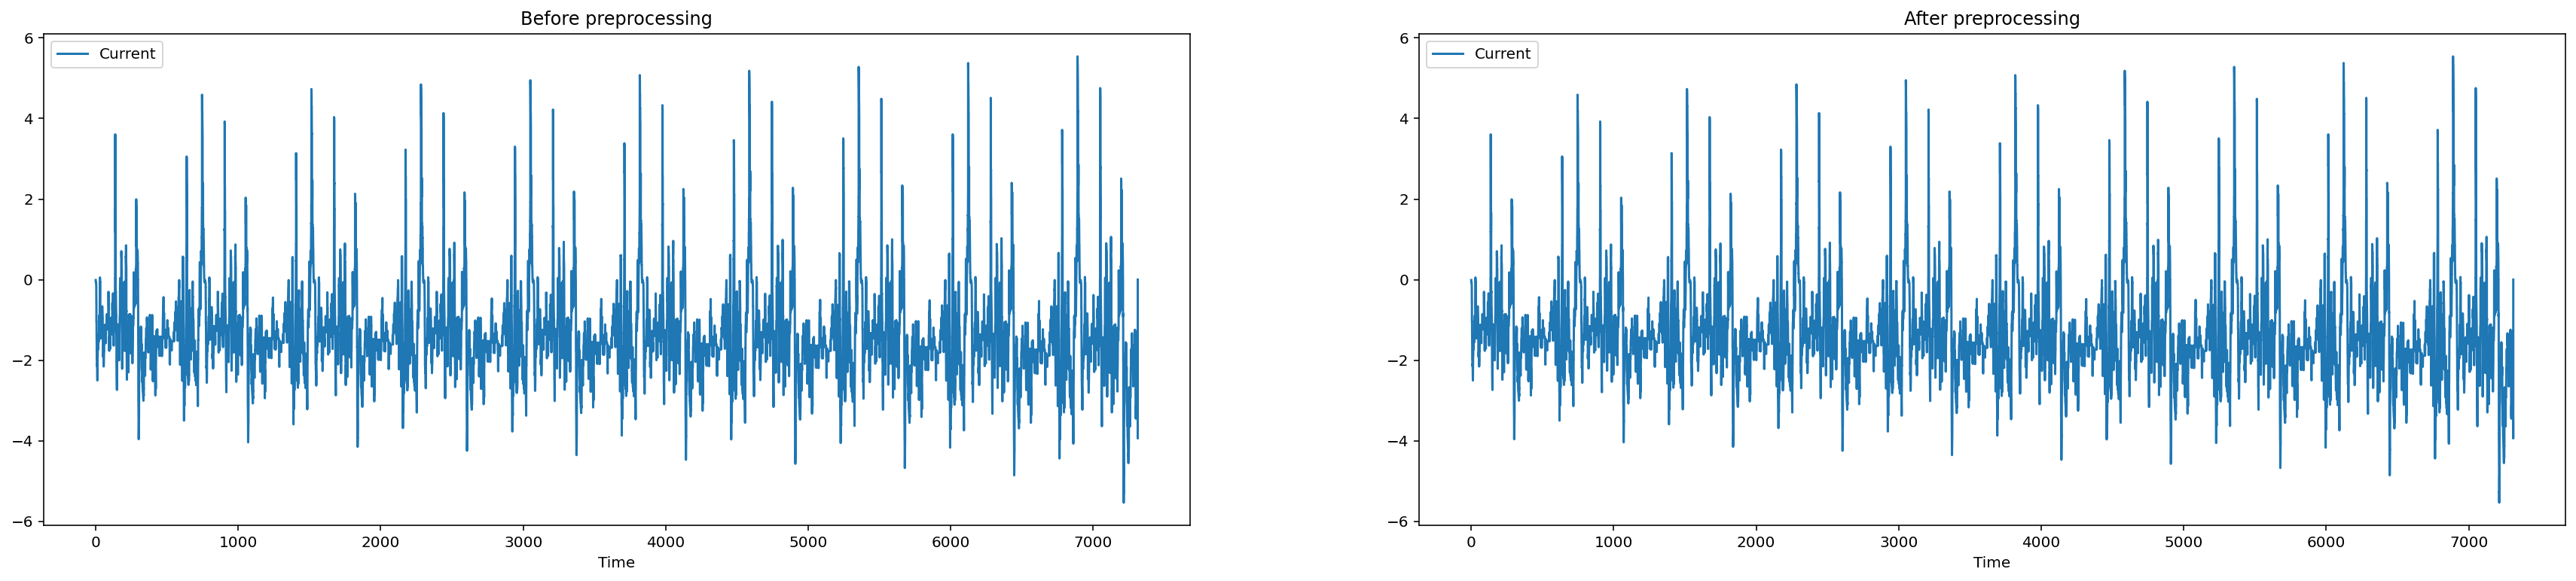

Read from 10_LA92.csv
Start from 61
Save to 10_LA92.pickle


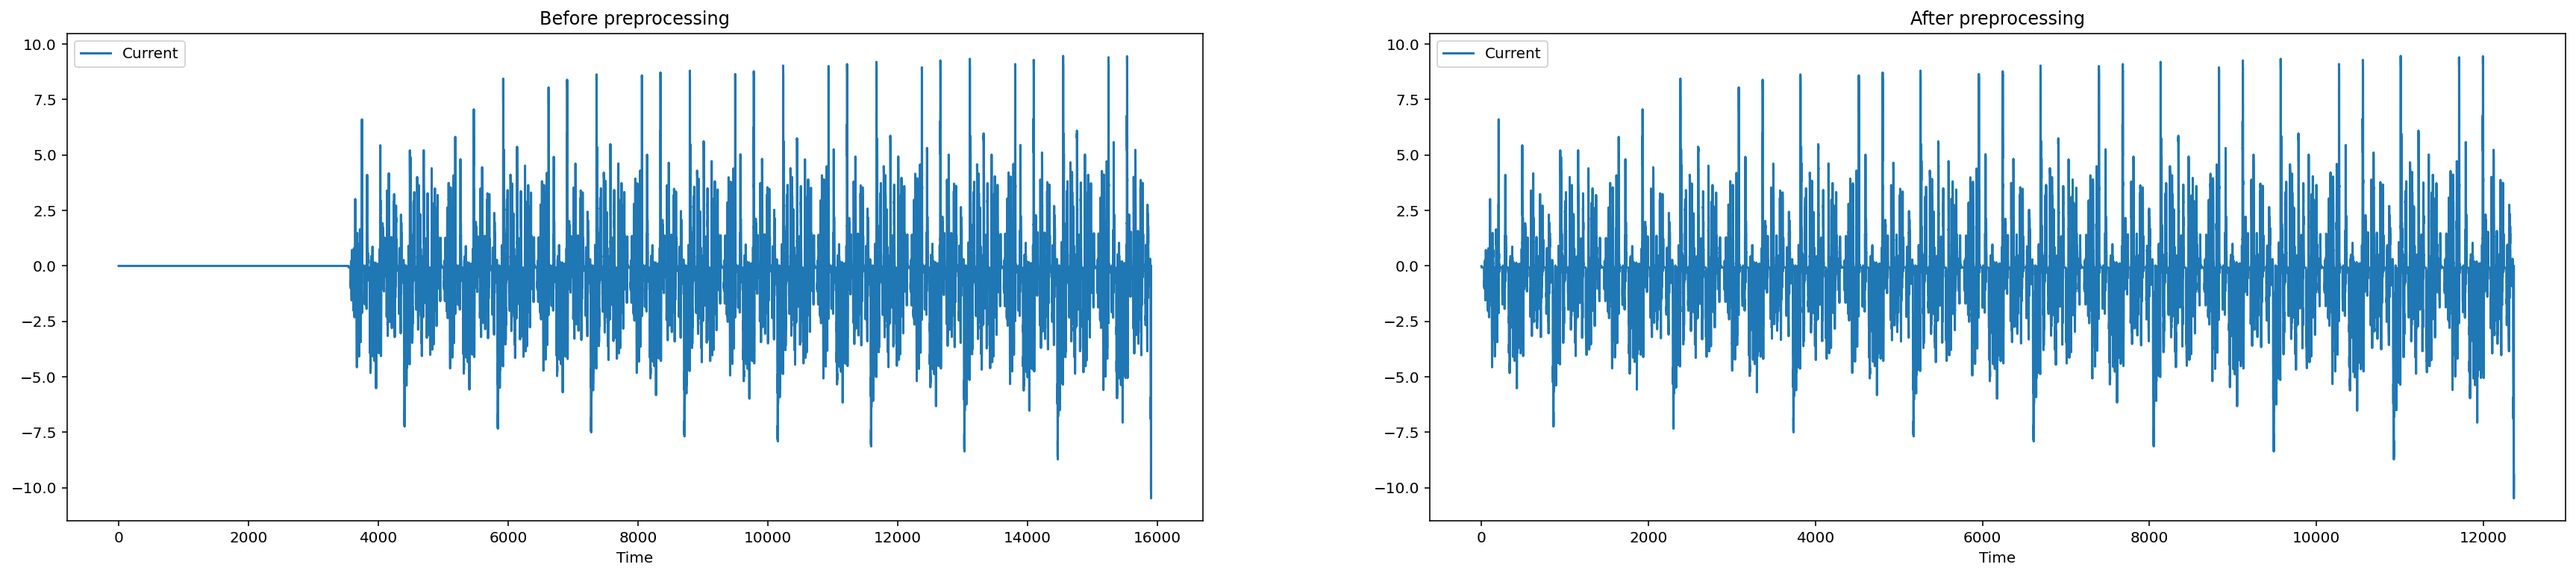

Read from 10_Cycle_3.csv
Start from 0
Save to 10_Cycle_3.pickle


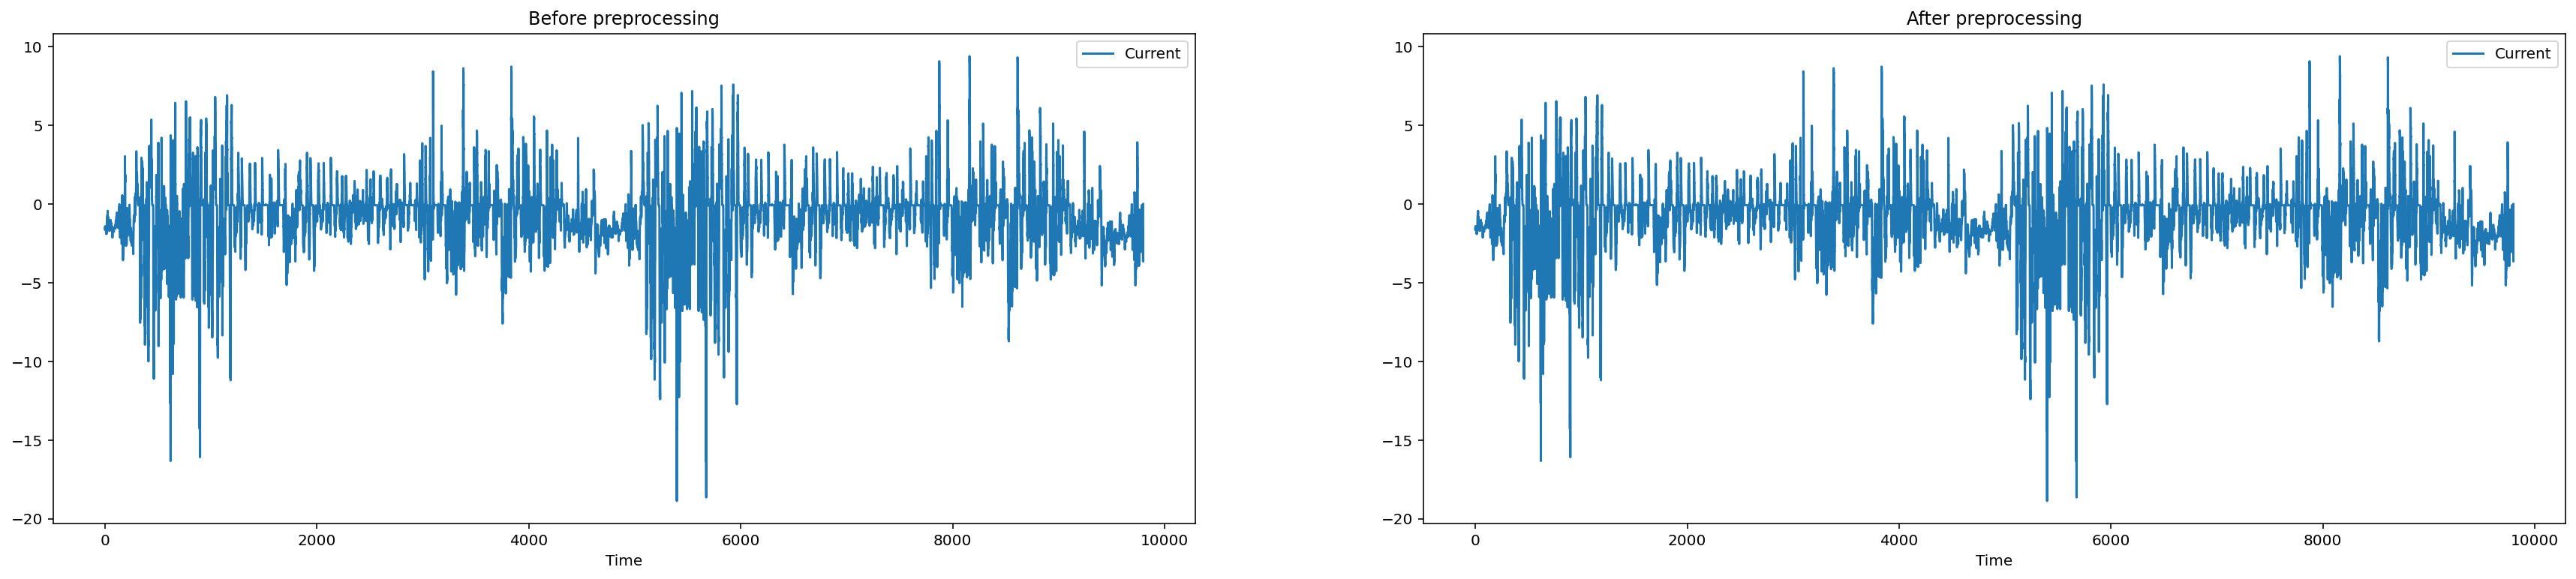

Read from 0_UDDS.csv
Start from 0
Save to 0_UDDS.pickle


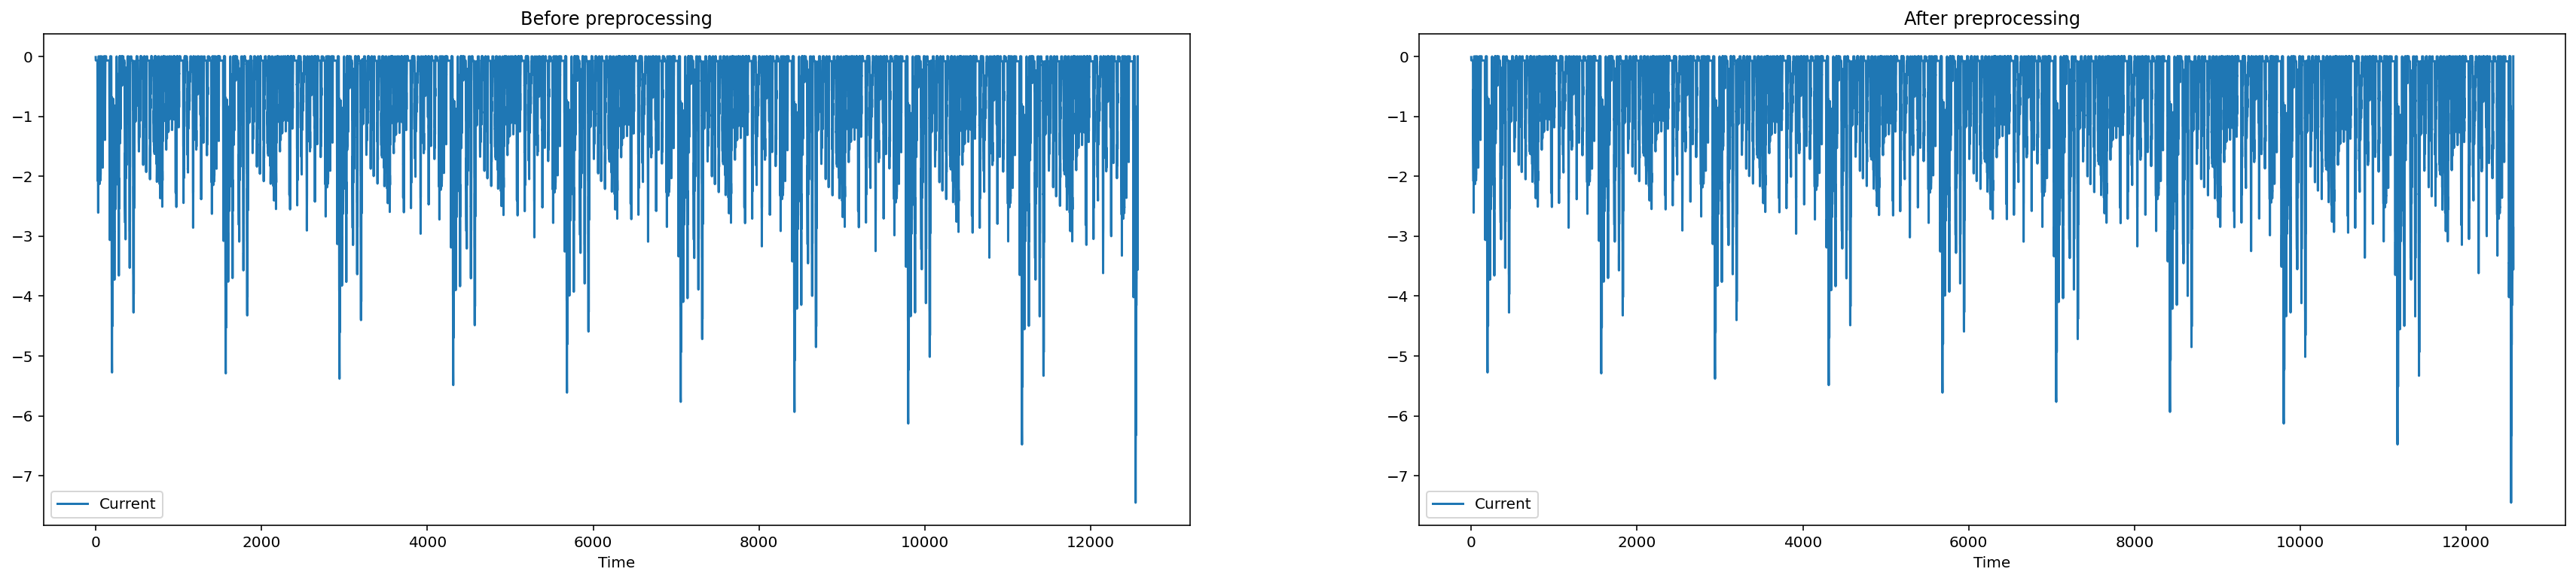

Read from 10_Cycle_2.csv
Start from 0
Save to 10_Cycle_2.pickle


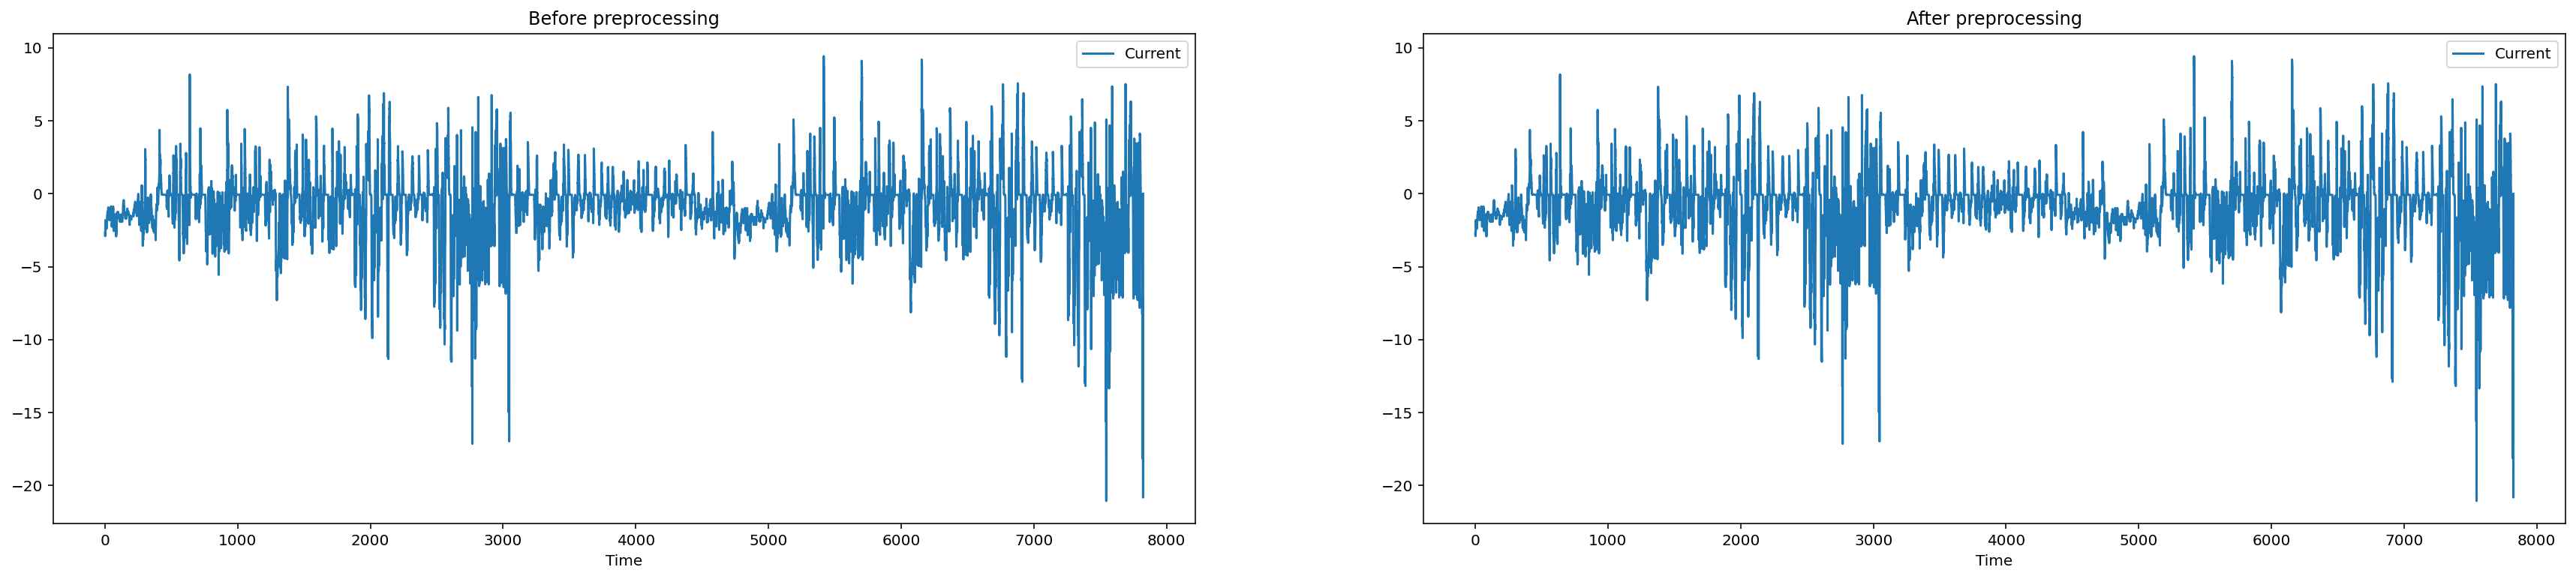

Read from -20_HWFET.csv
Start from 121
Save to -20_HWFET.pickle


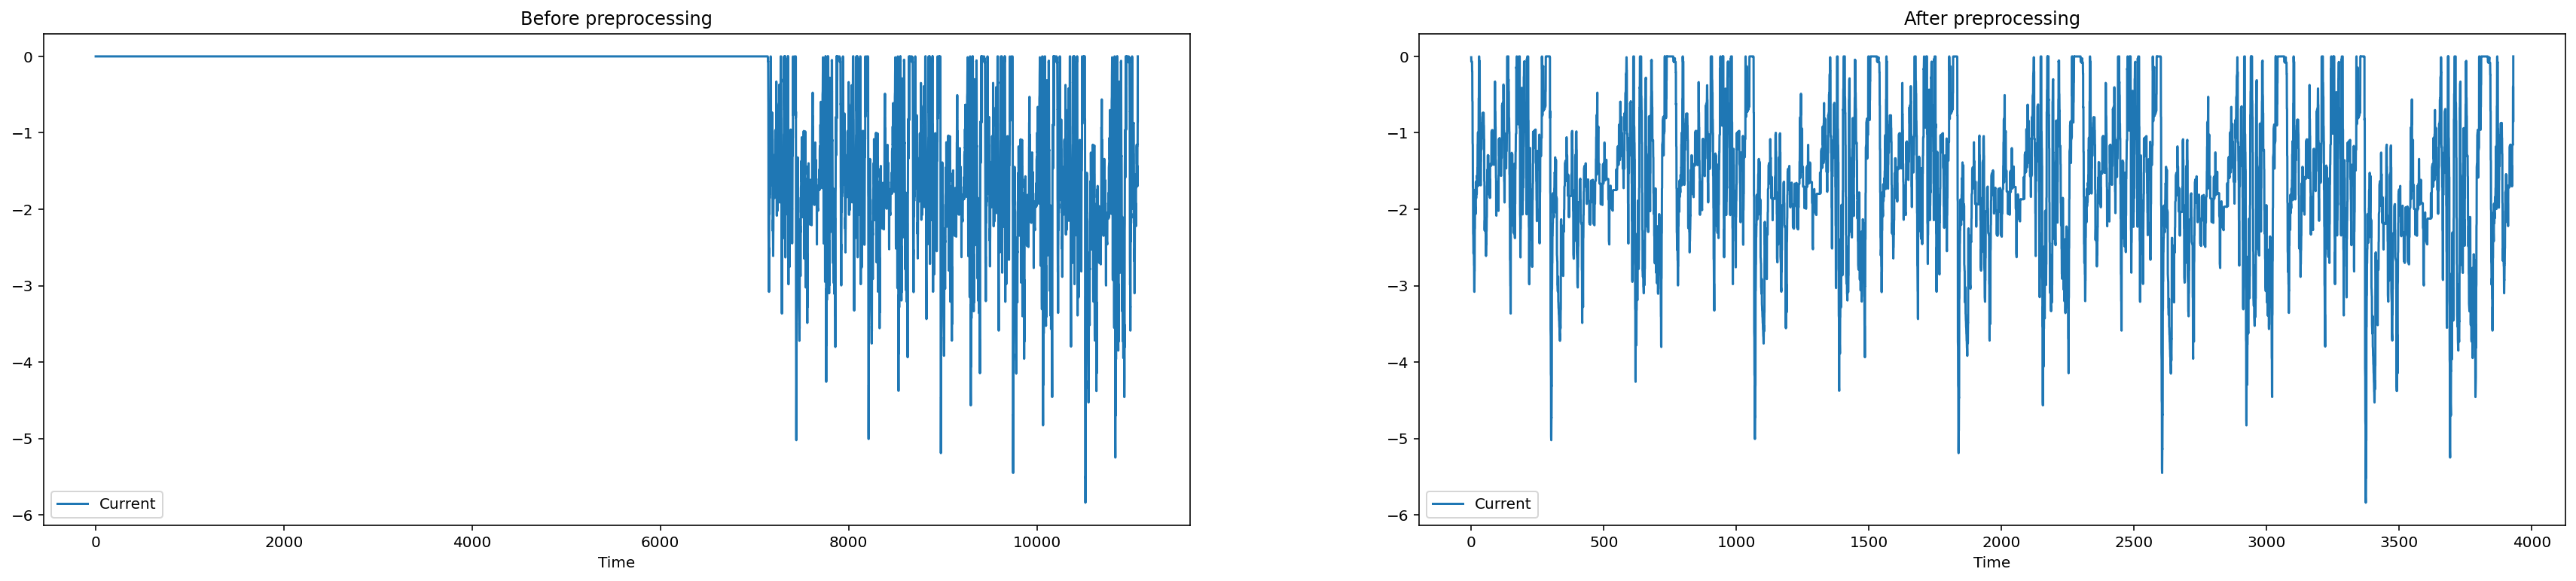

Read from -20_LA92.csv
Start from 121
Save to -20_LA92.pickle


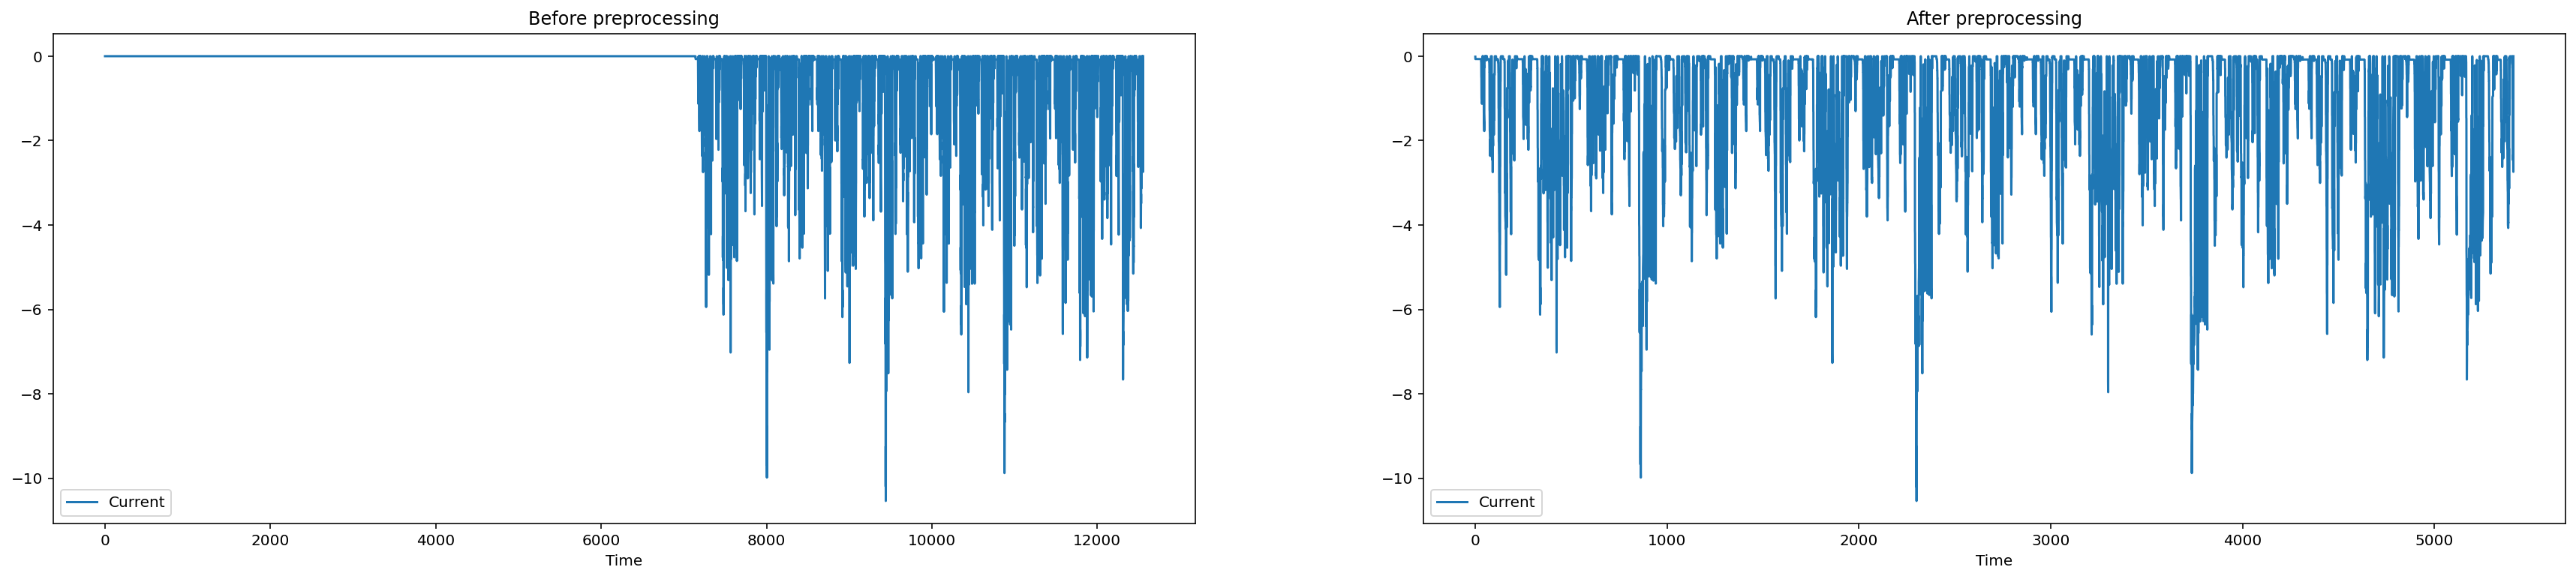

Read from 25_LA92.csv
Start from 0
Save to 25_LA92.pickle


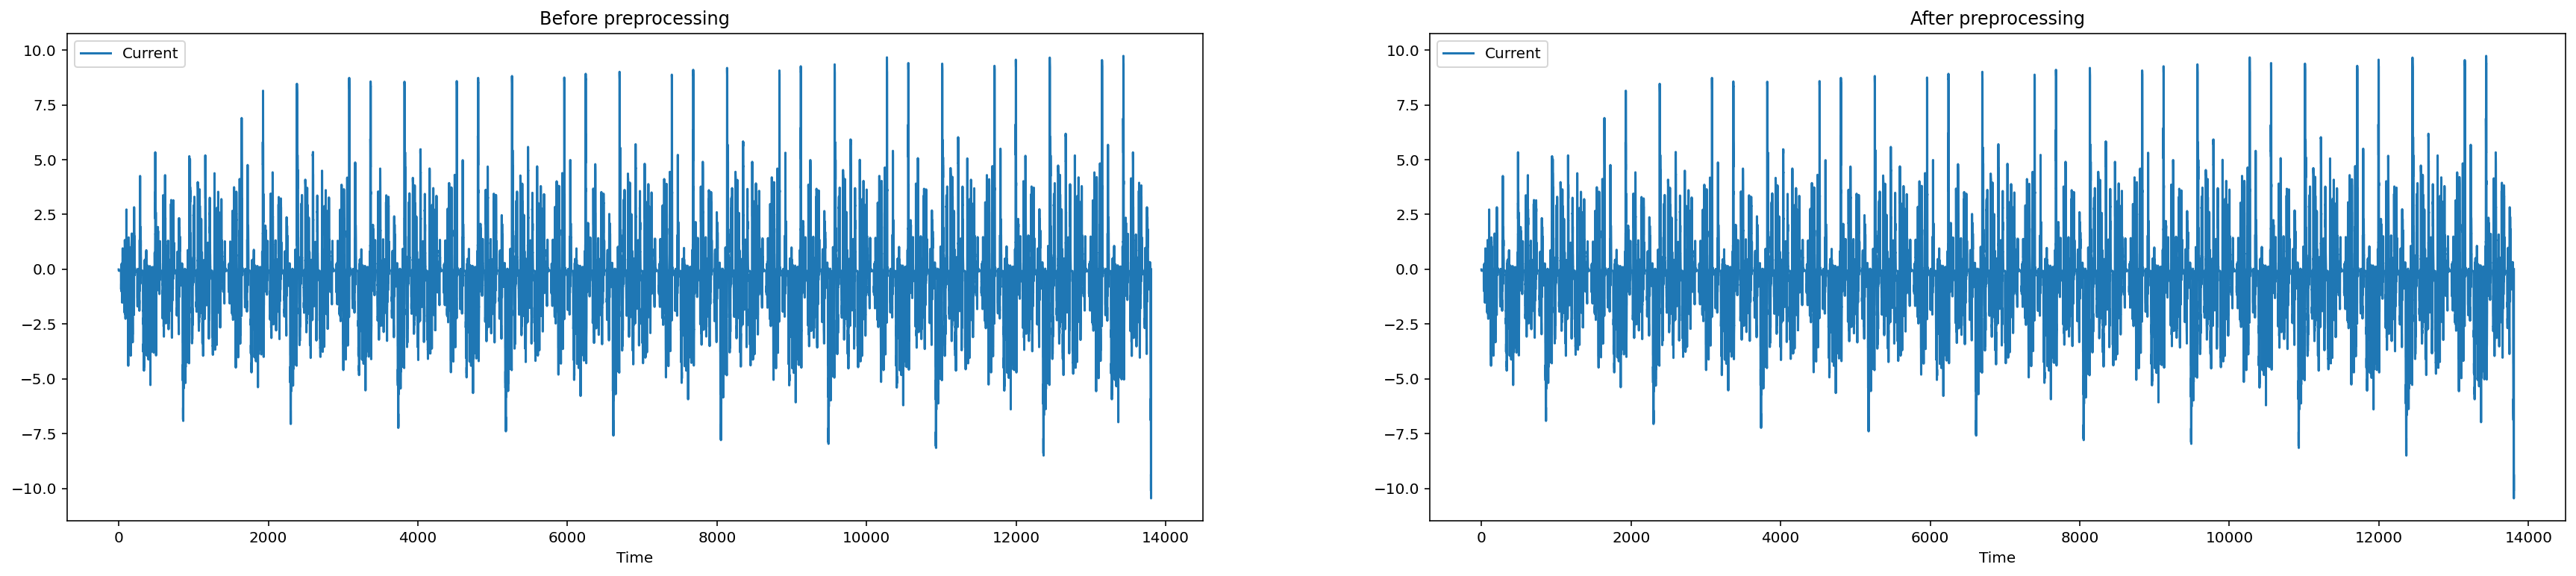

Read from 10_Cycle_4.csv
Start from 0
Save to 10_Cycle_4.pickle


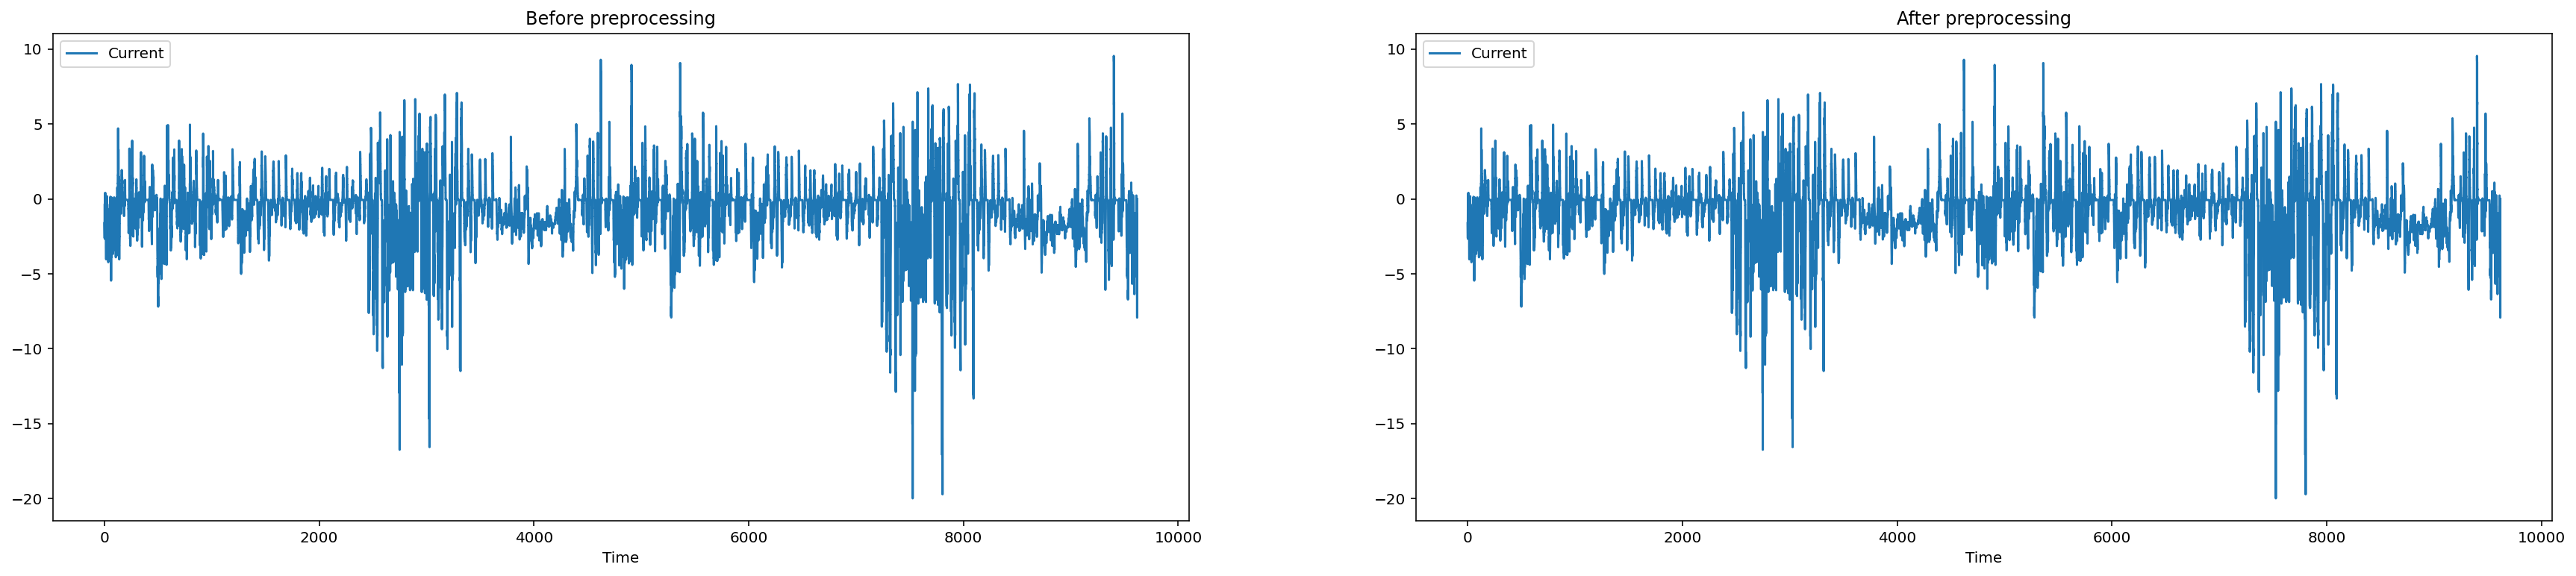

Read from 25_Cycle_4.csv
Start from 0
Save to 25_Cycle_4.pickle


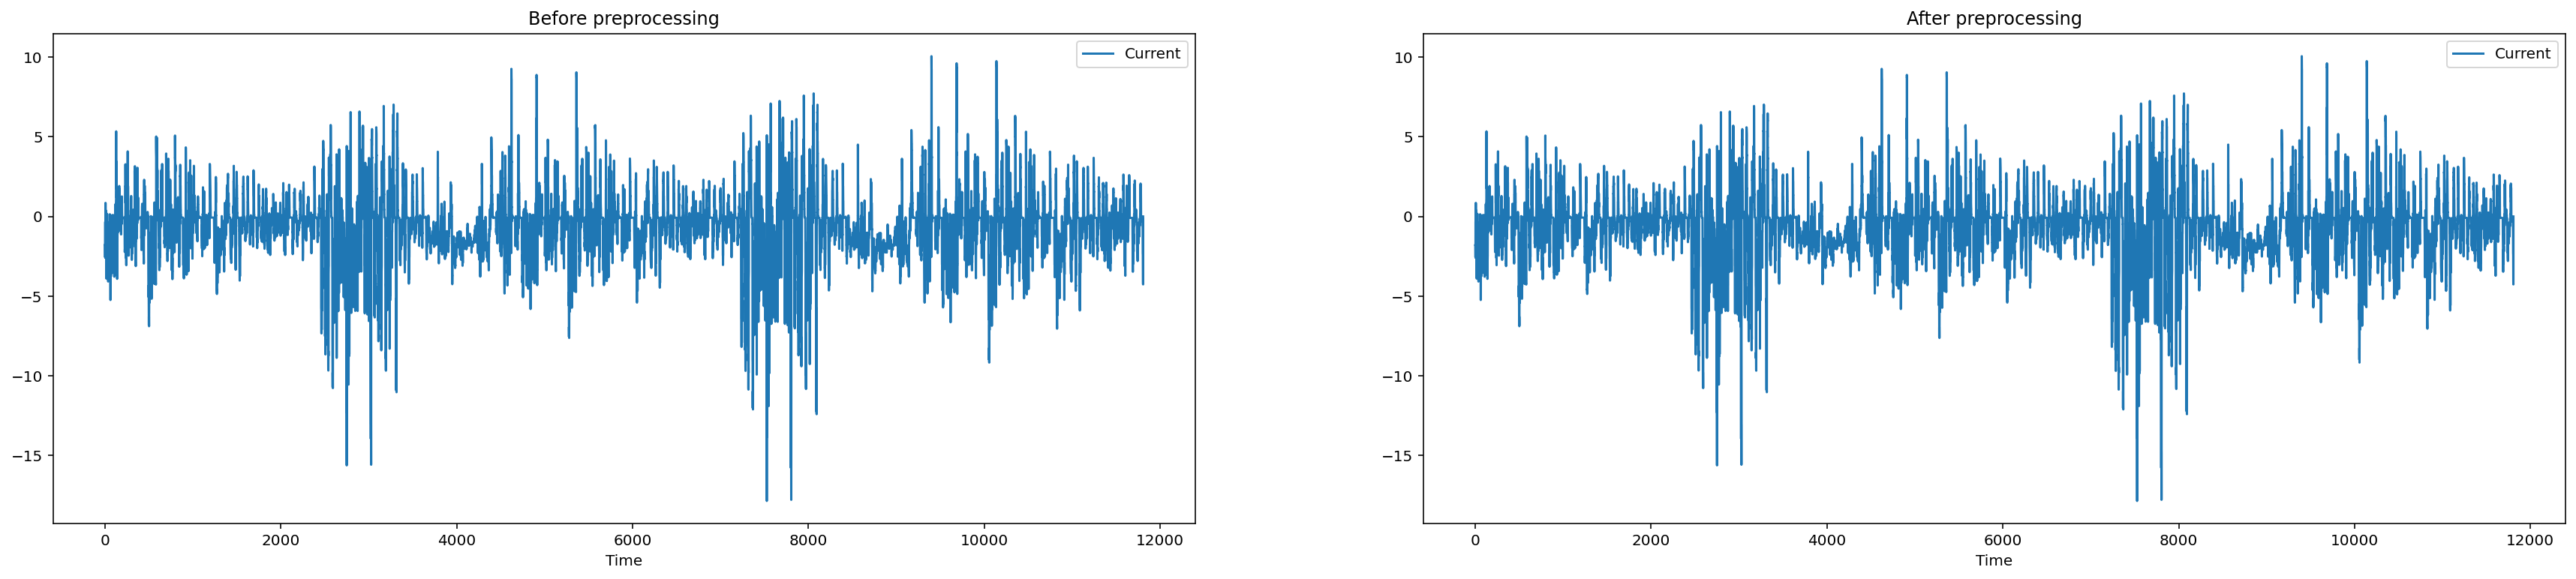

Read from -10_LA92.csv
Start from 121
Save to -10_LA92.pickle


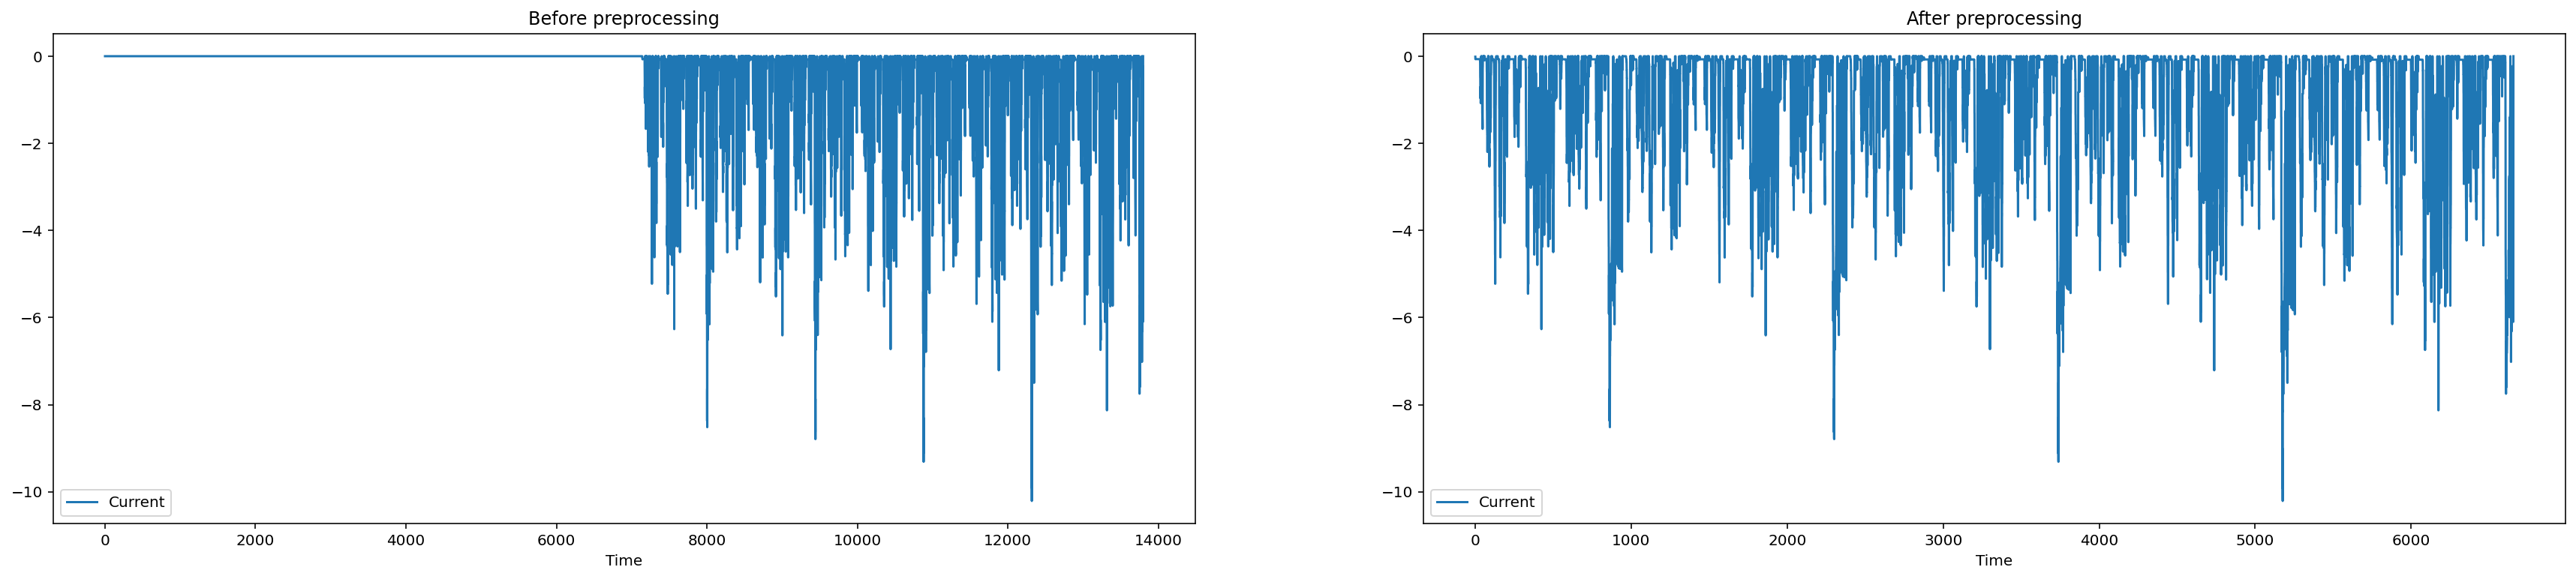

Read from -10_HWFET.csv
Start from 121
Save to -10_HWFET.pickle


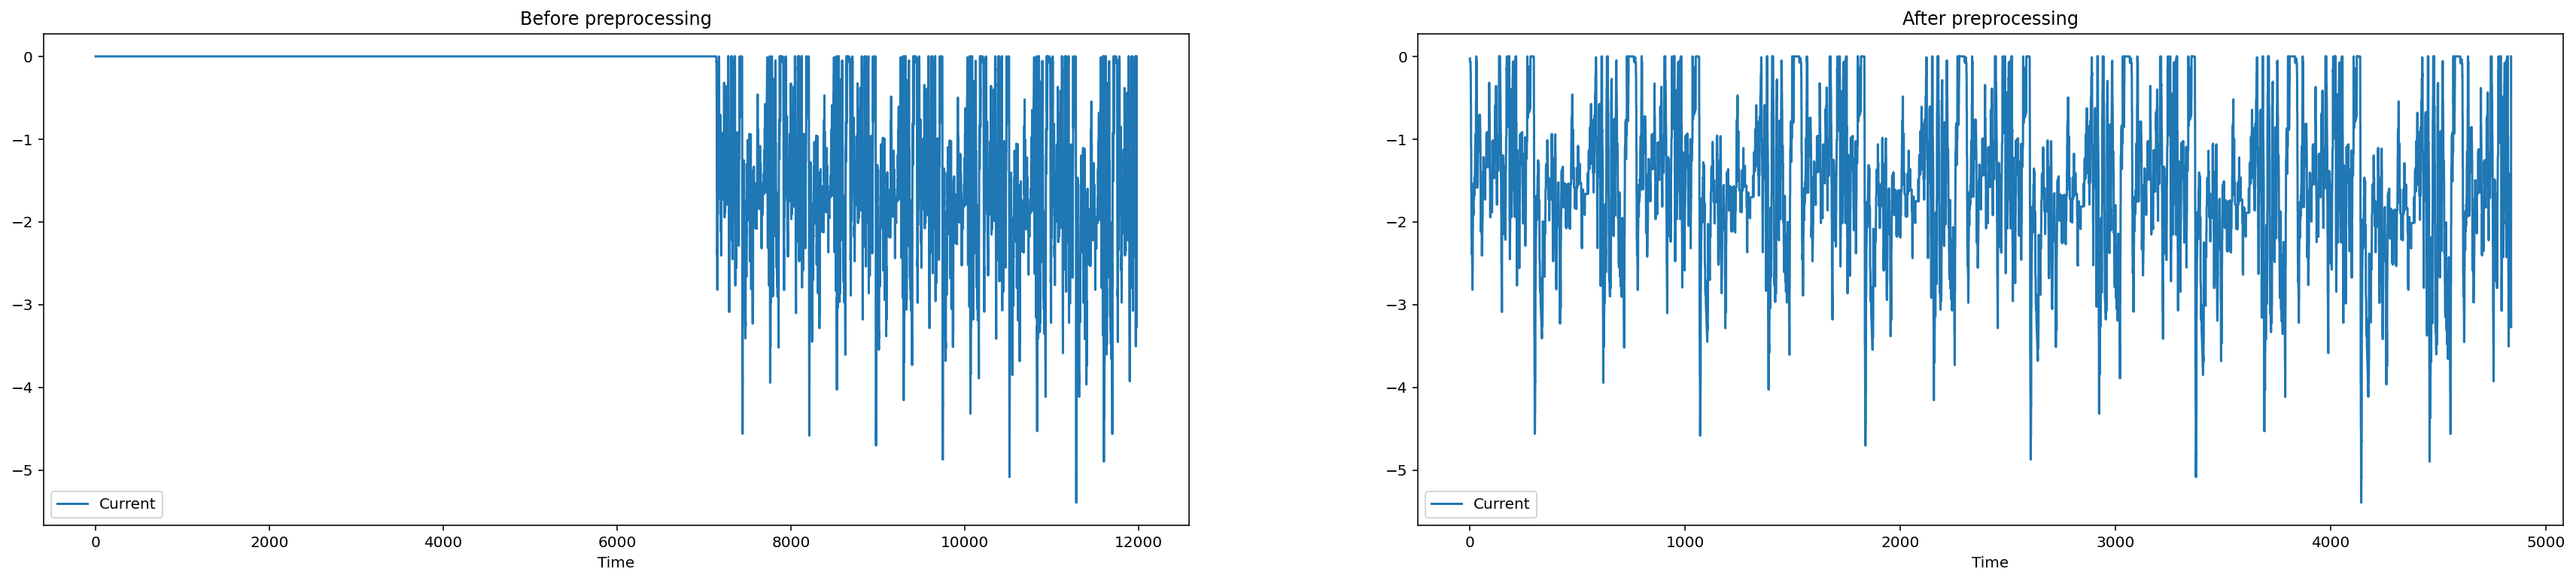

Read from 0_HWFET.csv
Start from 0
Save to 0_HWFET.pickle


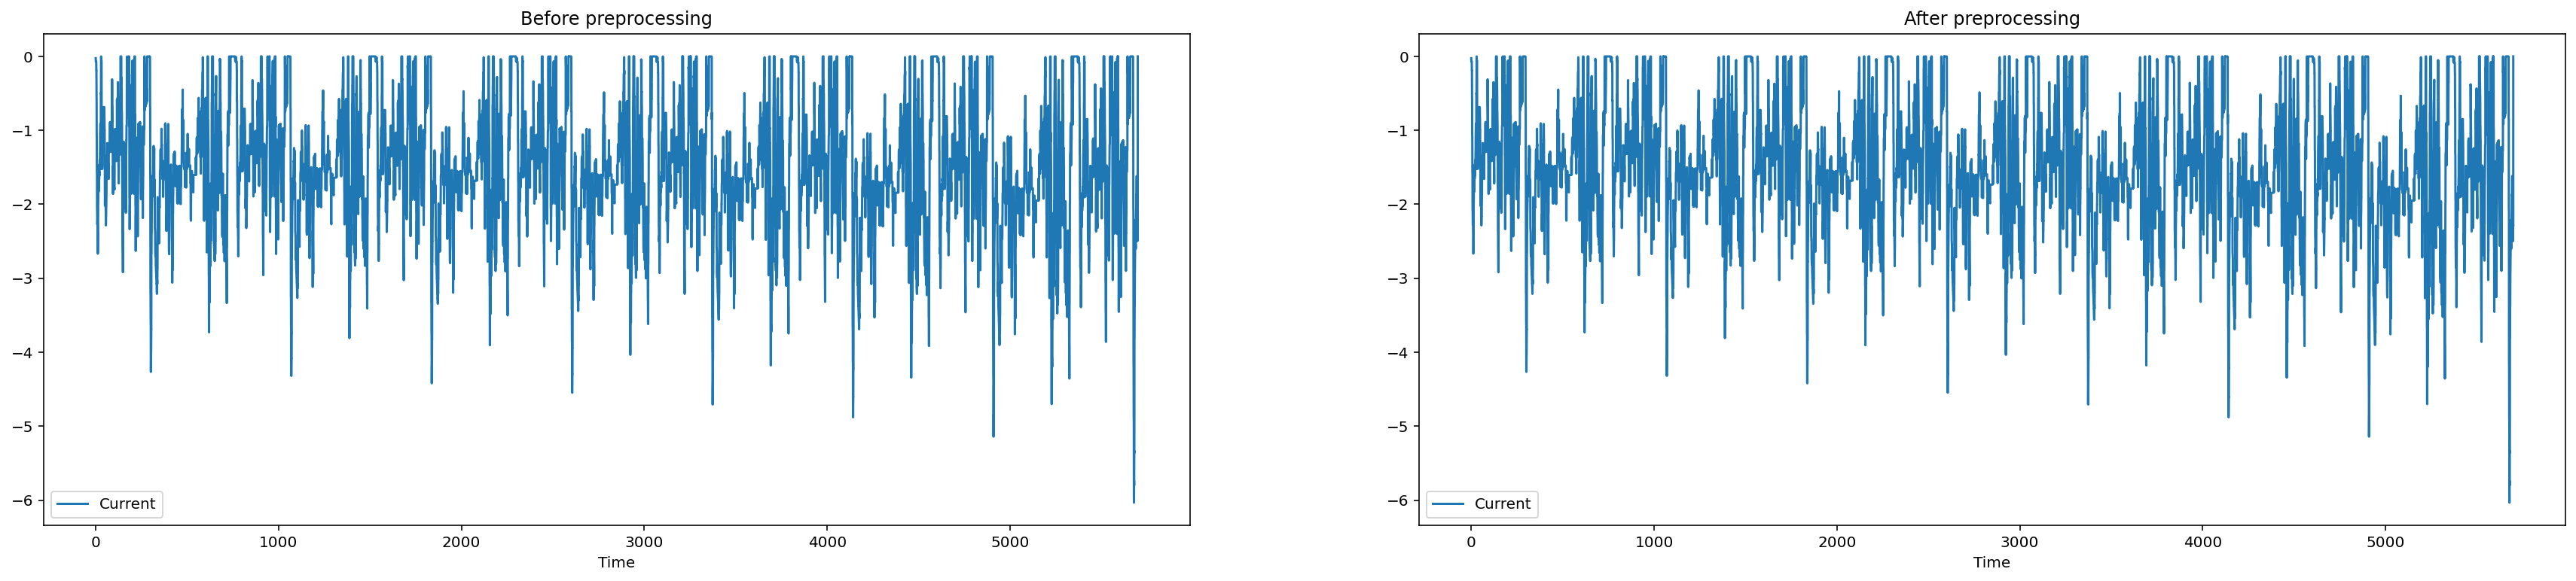

Read from 25_Cycle_2.csv
Start from 0
Save to 25_Cycle_2.pickle


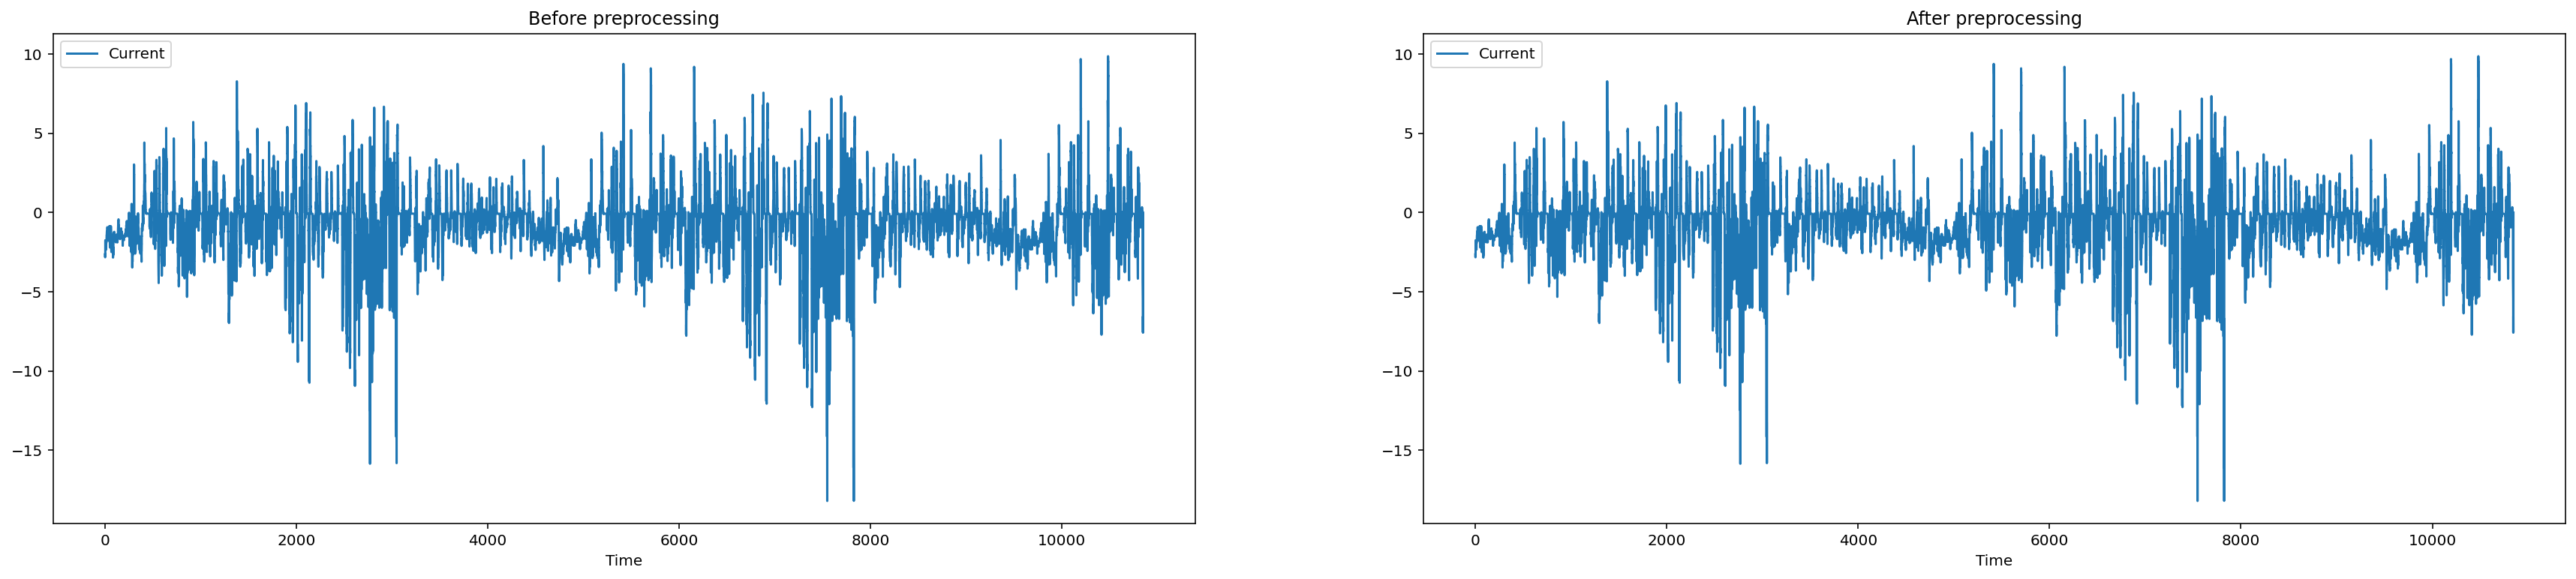

Read from 25_Cycle_3.csv
Start from 0
Save to 25_Cycle_3.pickle


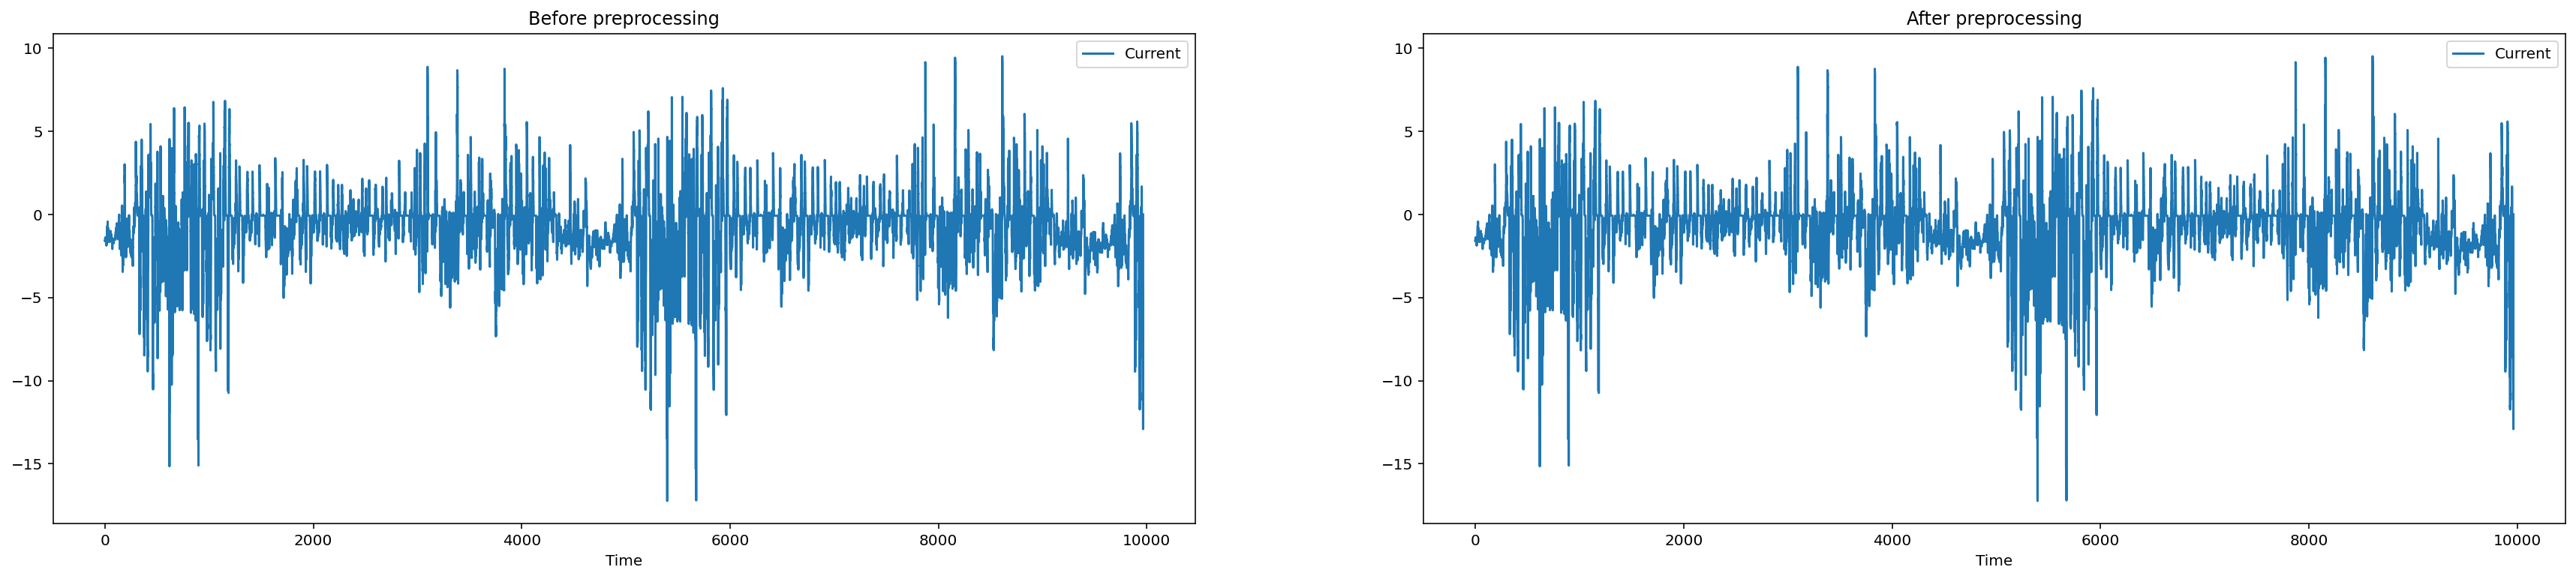

Read from -10_Cycle_2.csv
Start from 0
Save to -10_Cycle_2.pickle


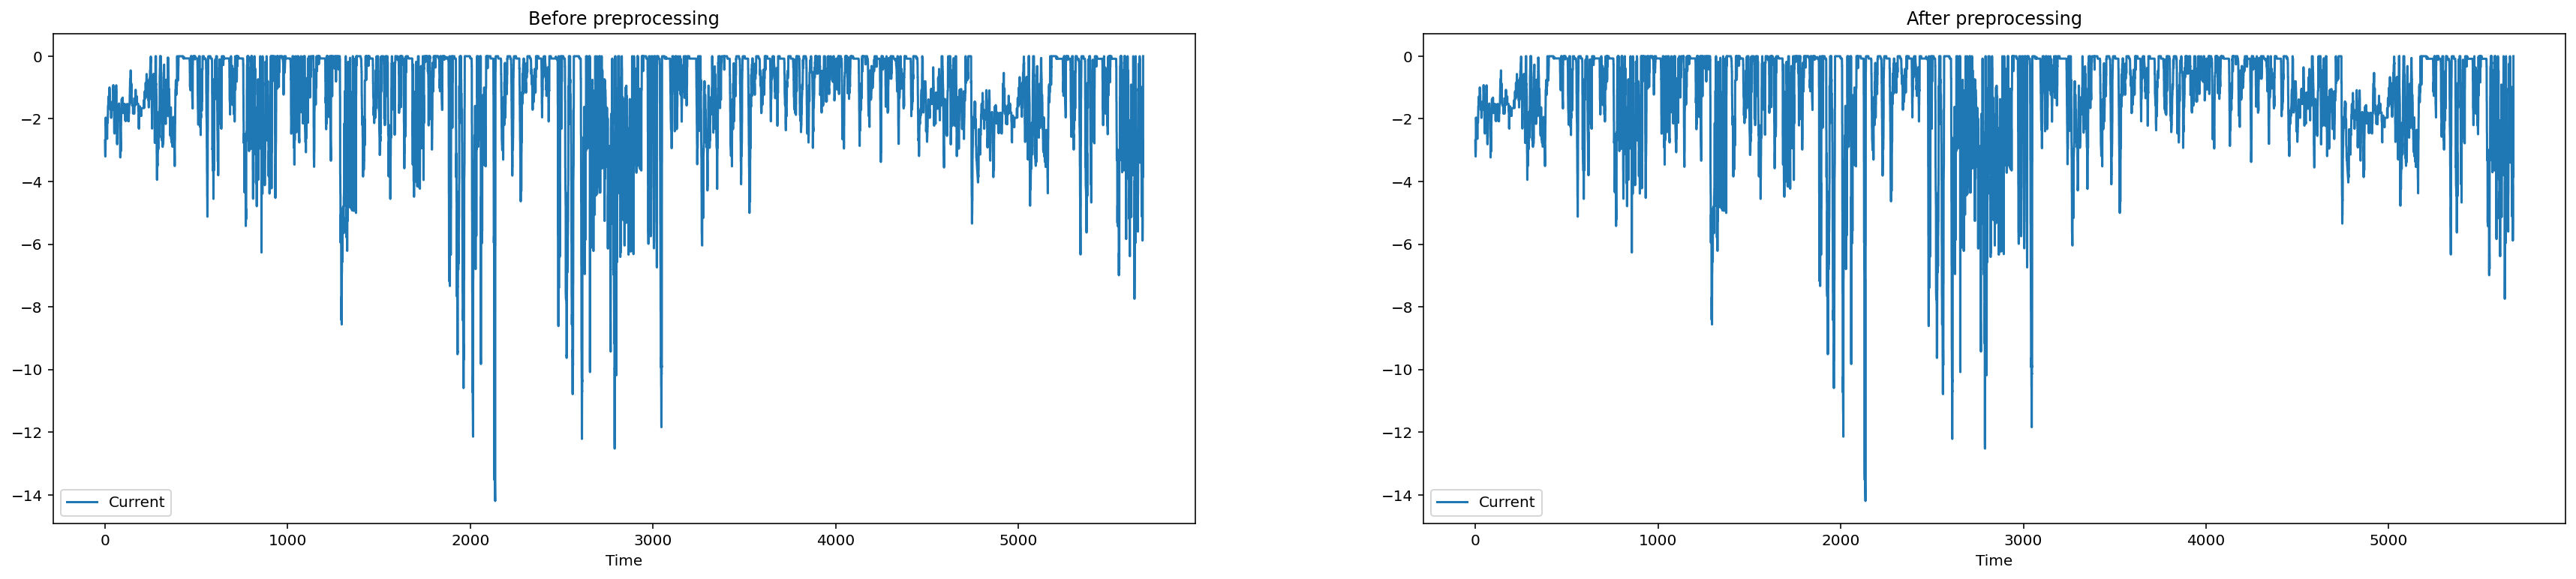

Read from 0_Cycle_3.csv
Start from 0
Save to 0_Cycle_3.pickle


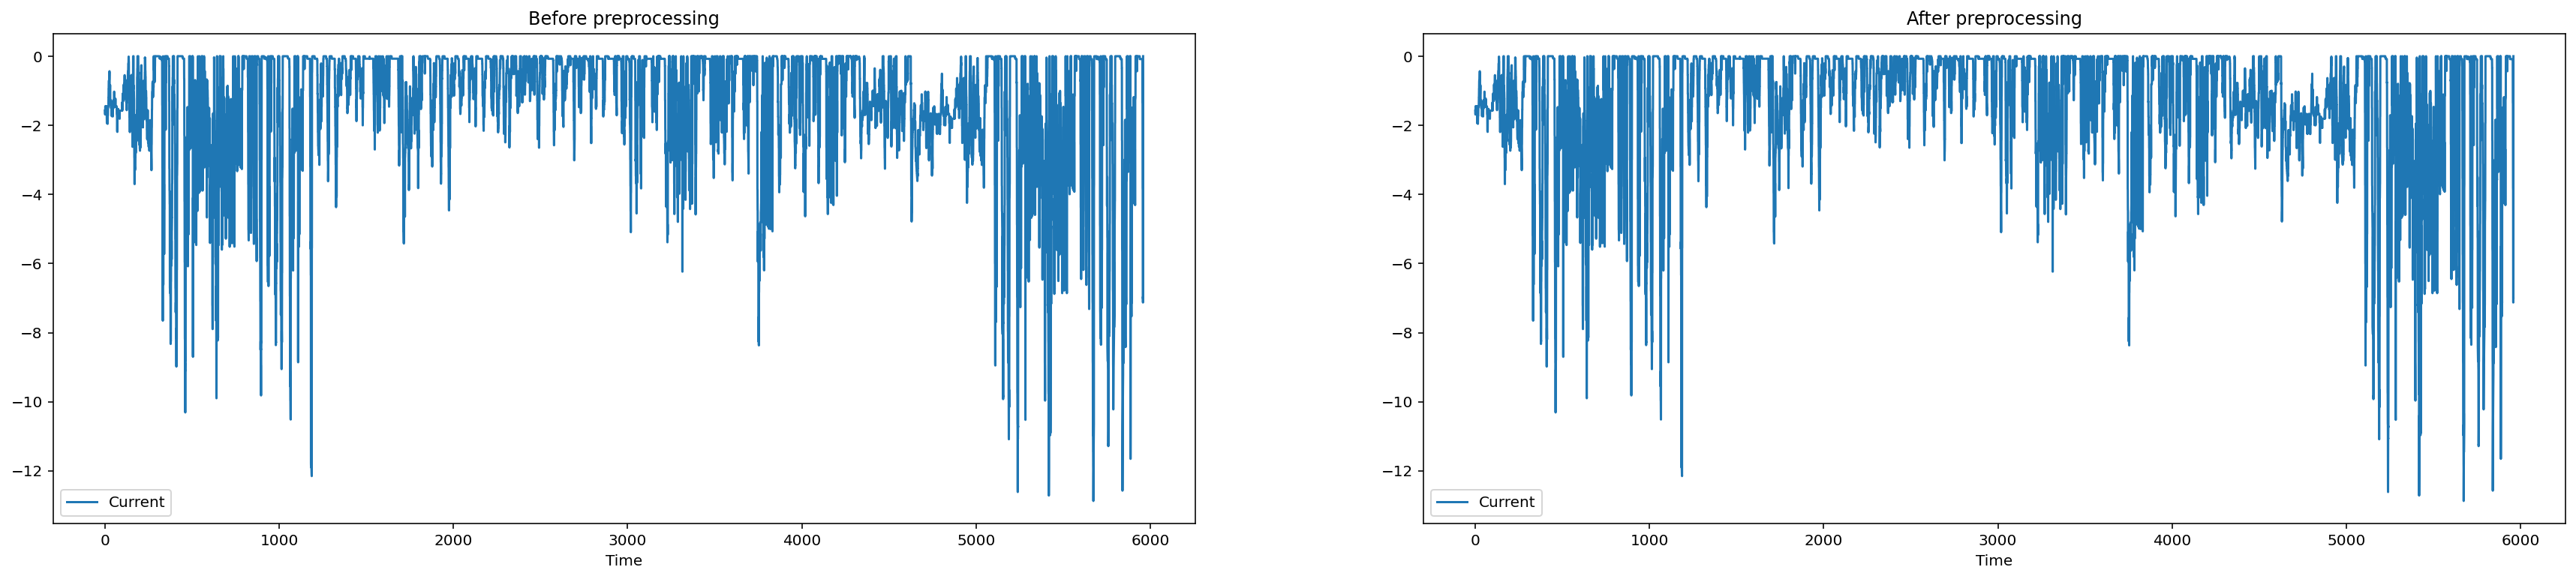

Read from 0_Cycle_2.csv
Start from 0
Save to 0_Cycle_2.pickle


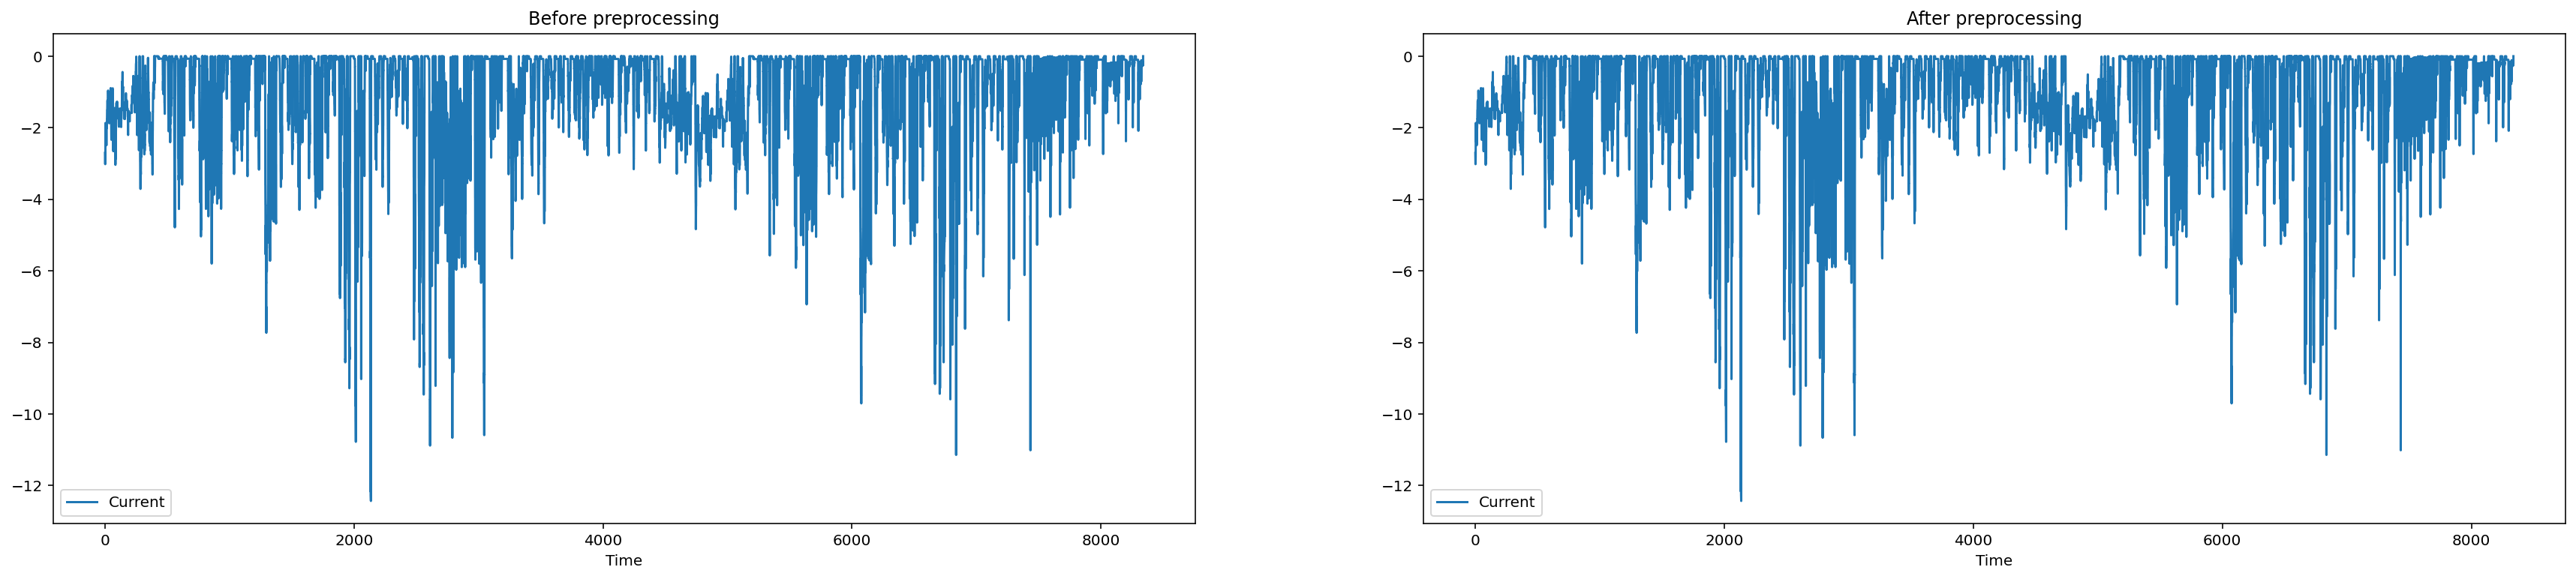

Read from -10_Cycle_3.csv
Start from 0
Save to -10_Cycle_3.pickle


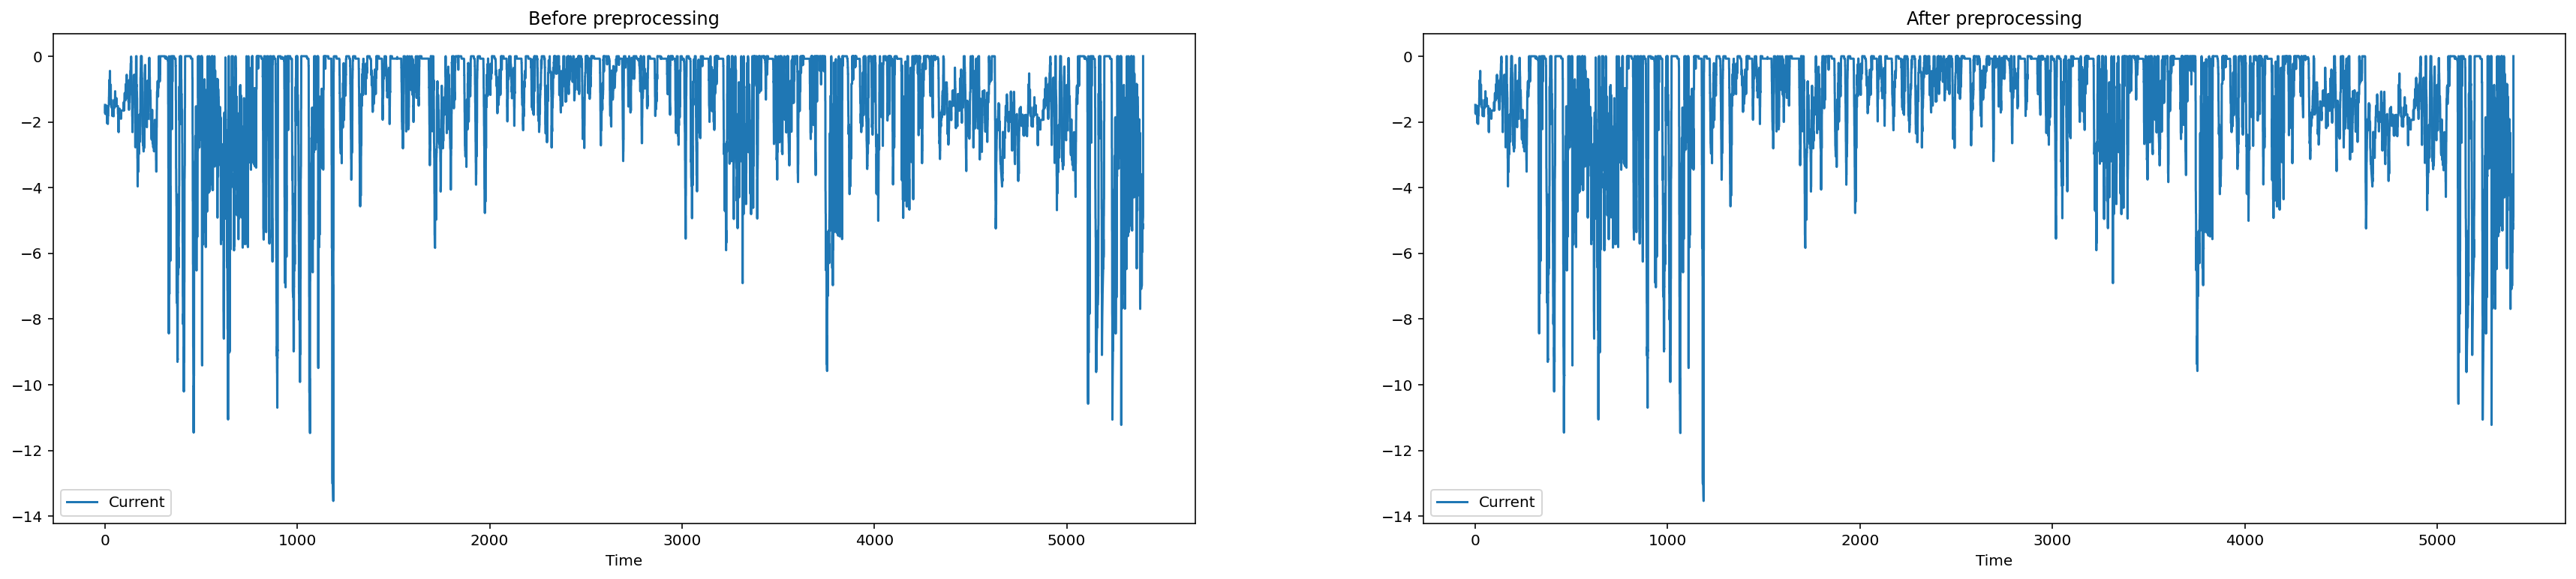

Read from 0_LA92.csv
Start from 121
Save to 0_LA92.pickle


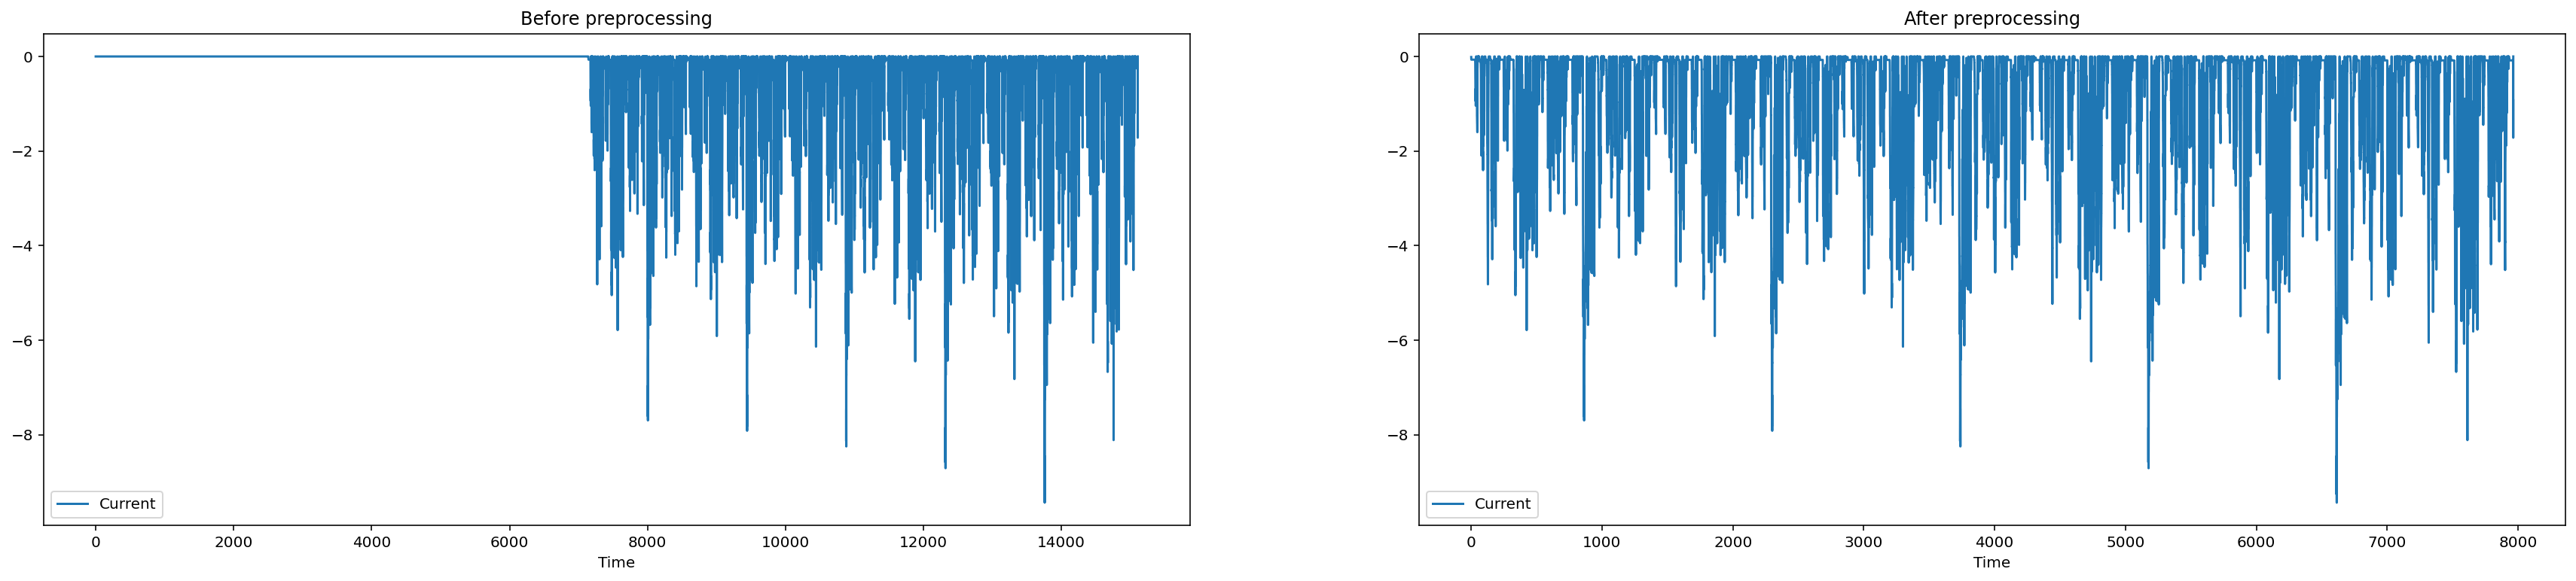

Read from -10_Cycle_4.csv
Start from 0
Save to -10_Cycle_4.pickle


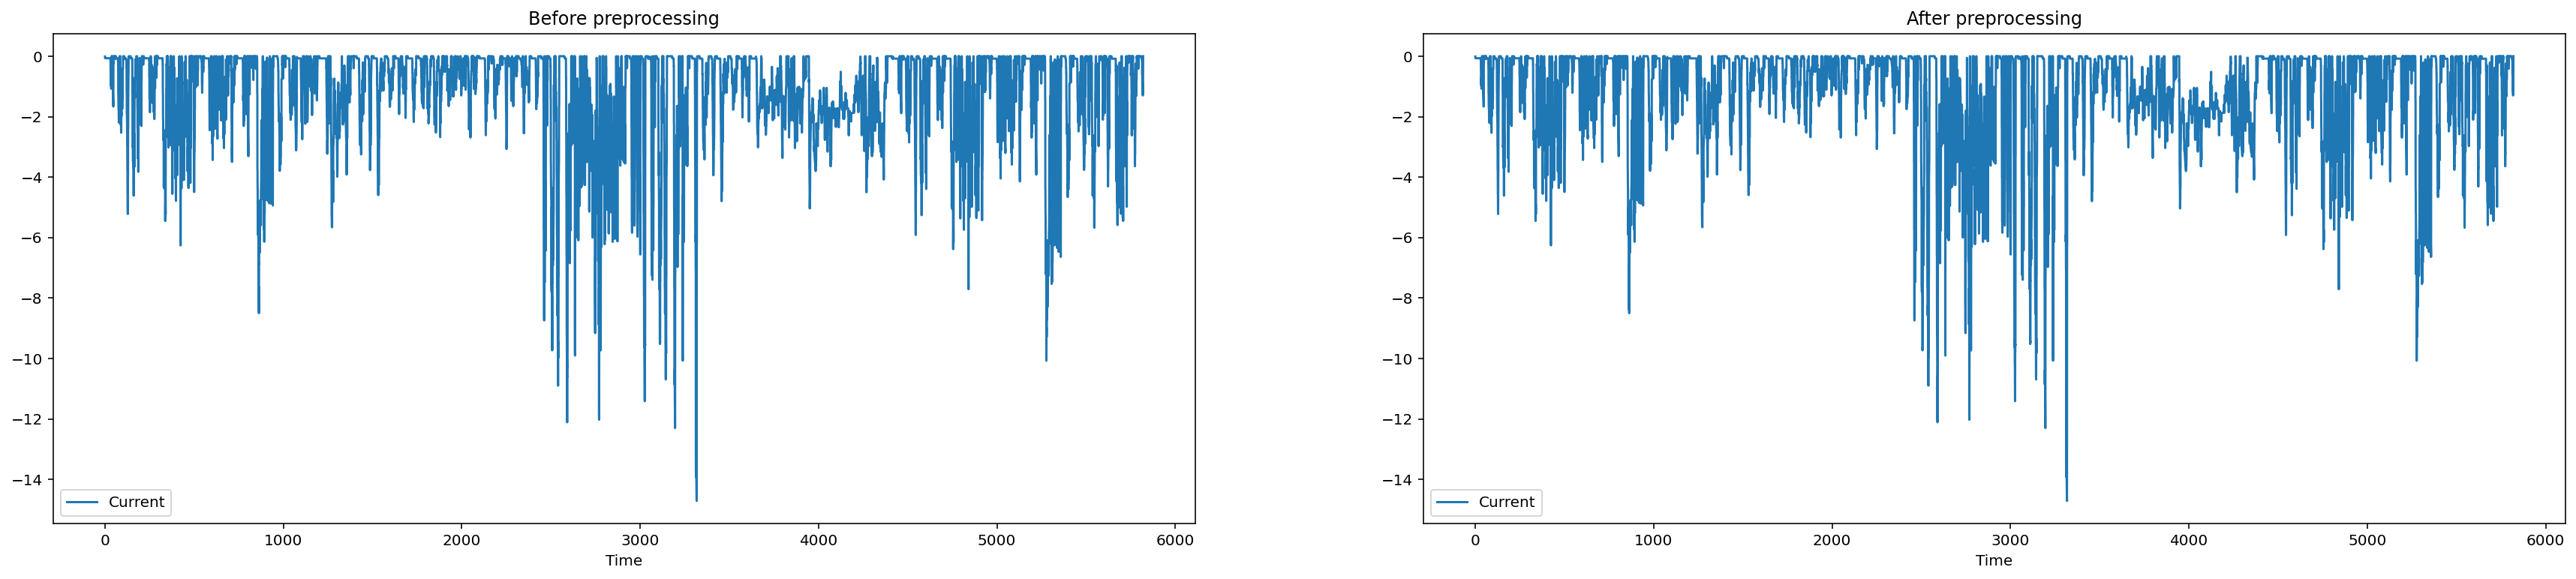

Read from 10_UDDS.csv
Start from 61
Save to 10_UDDS.pickle


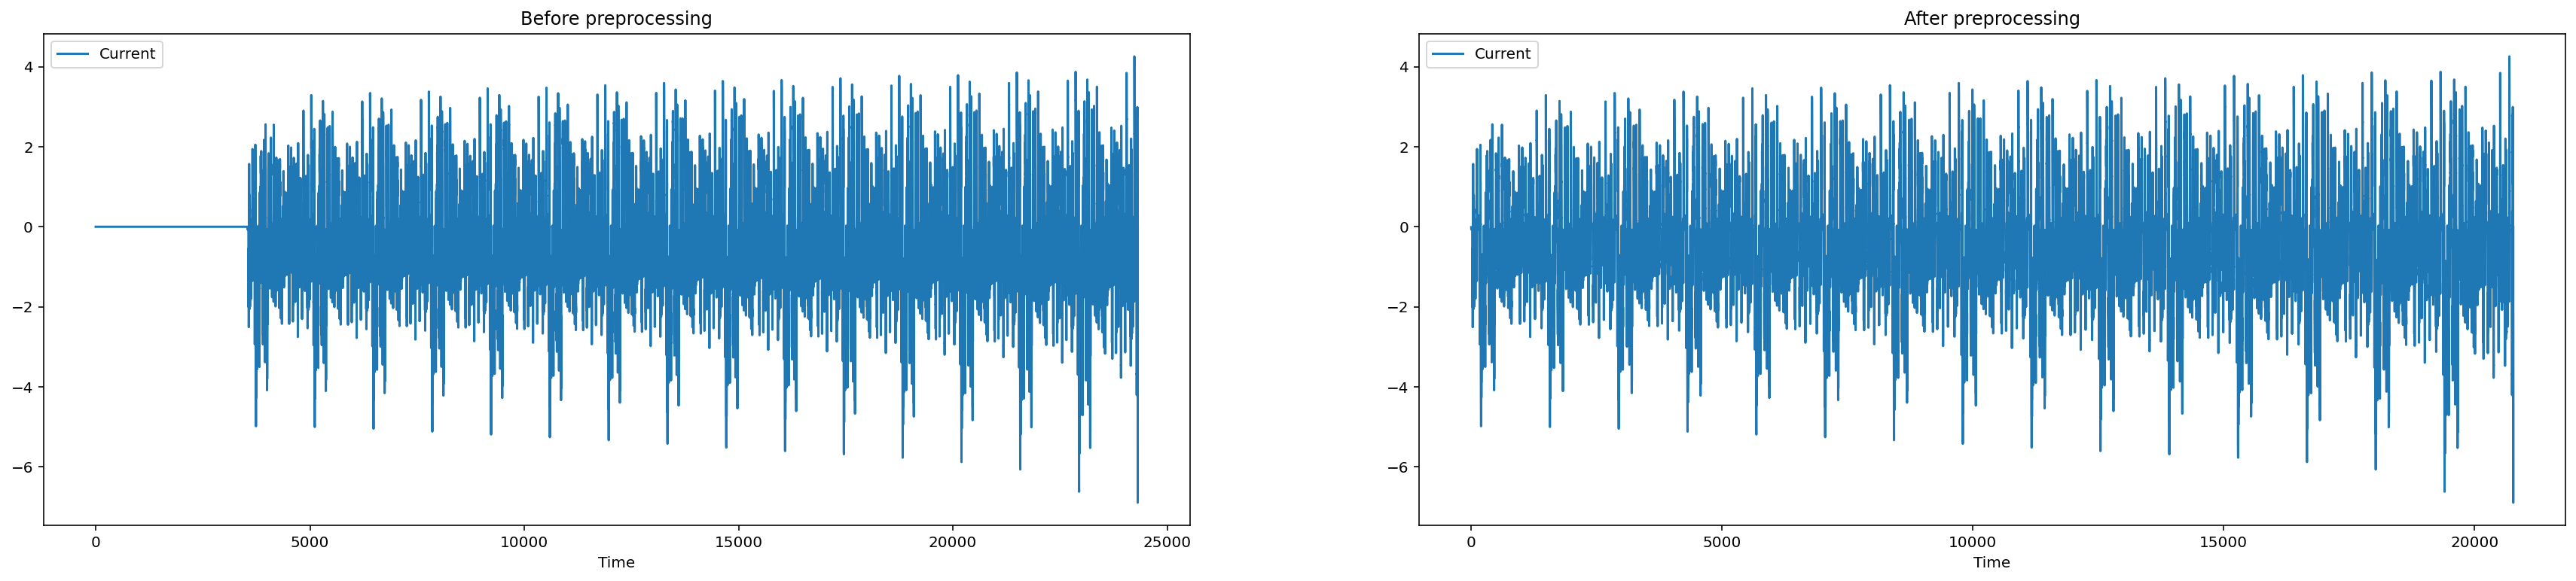

Read from 0_Cycle_4.csv
Start from 0
Save to 0_Cycle_4.pickle


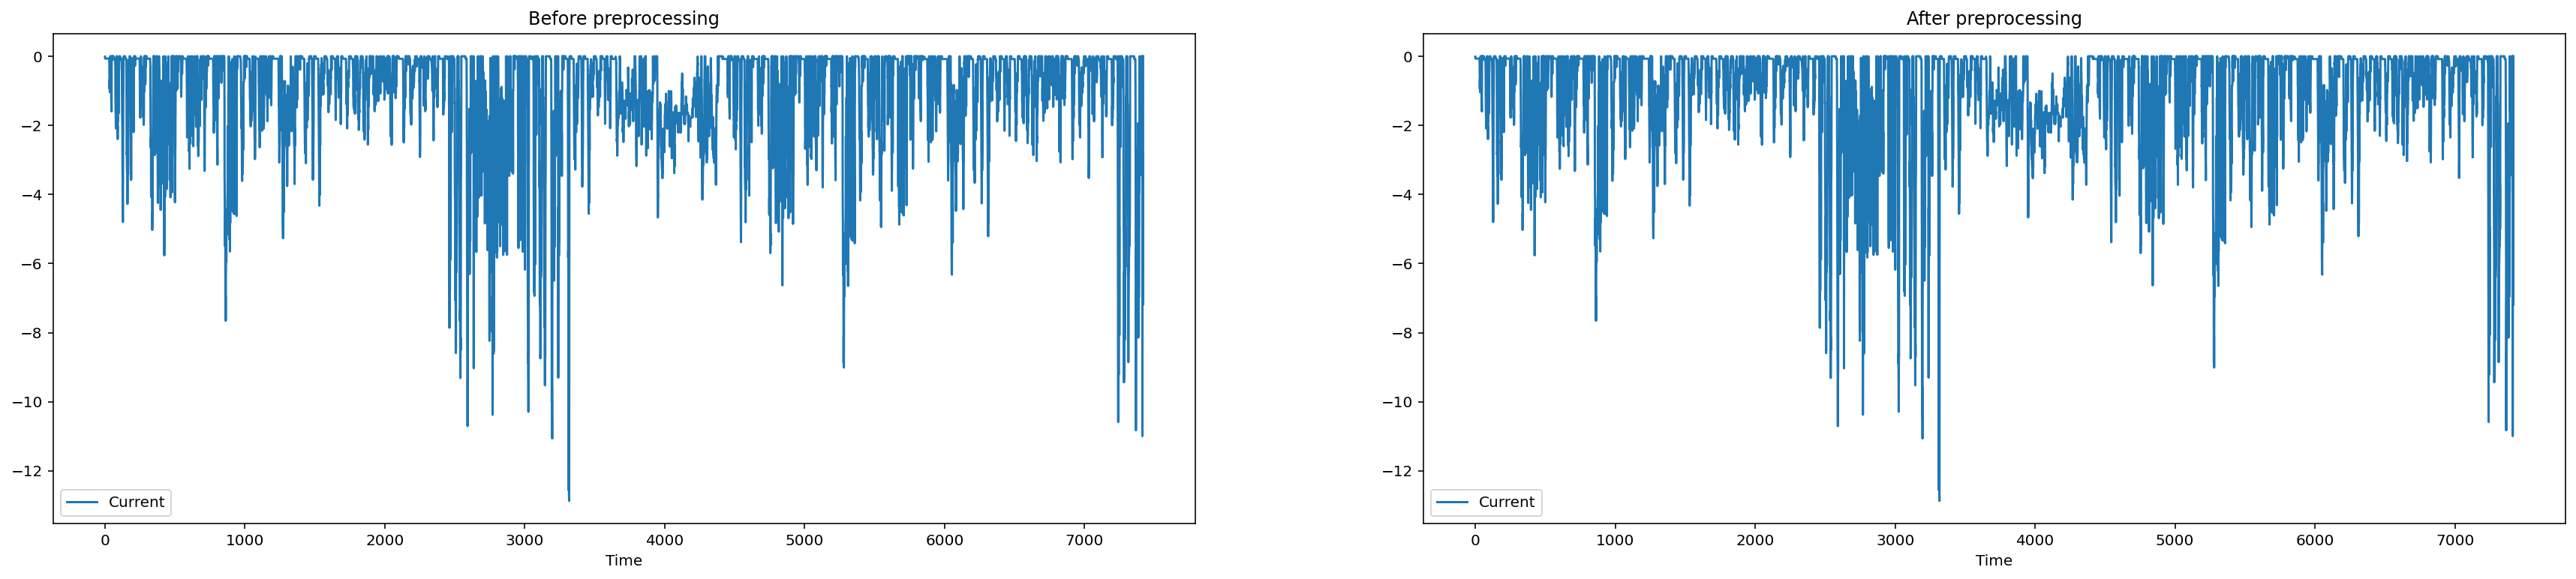

Read from -20_UDDS.csv
Start from 121
Save to -20_UDDS.pickle


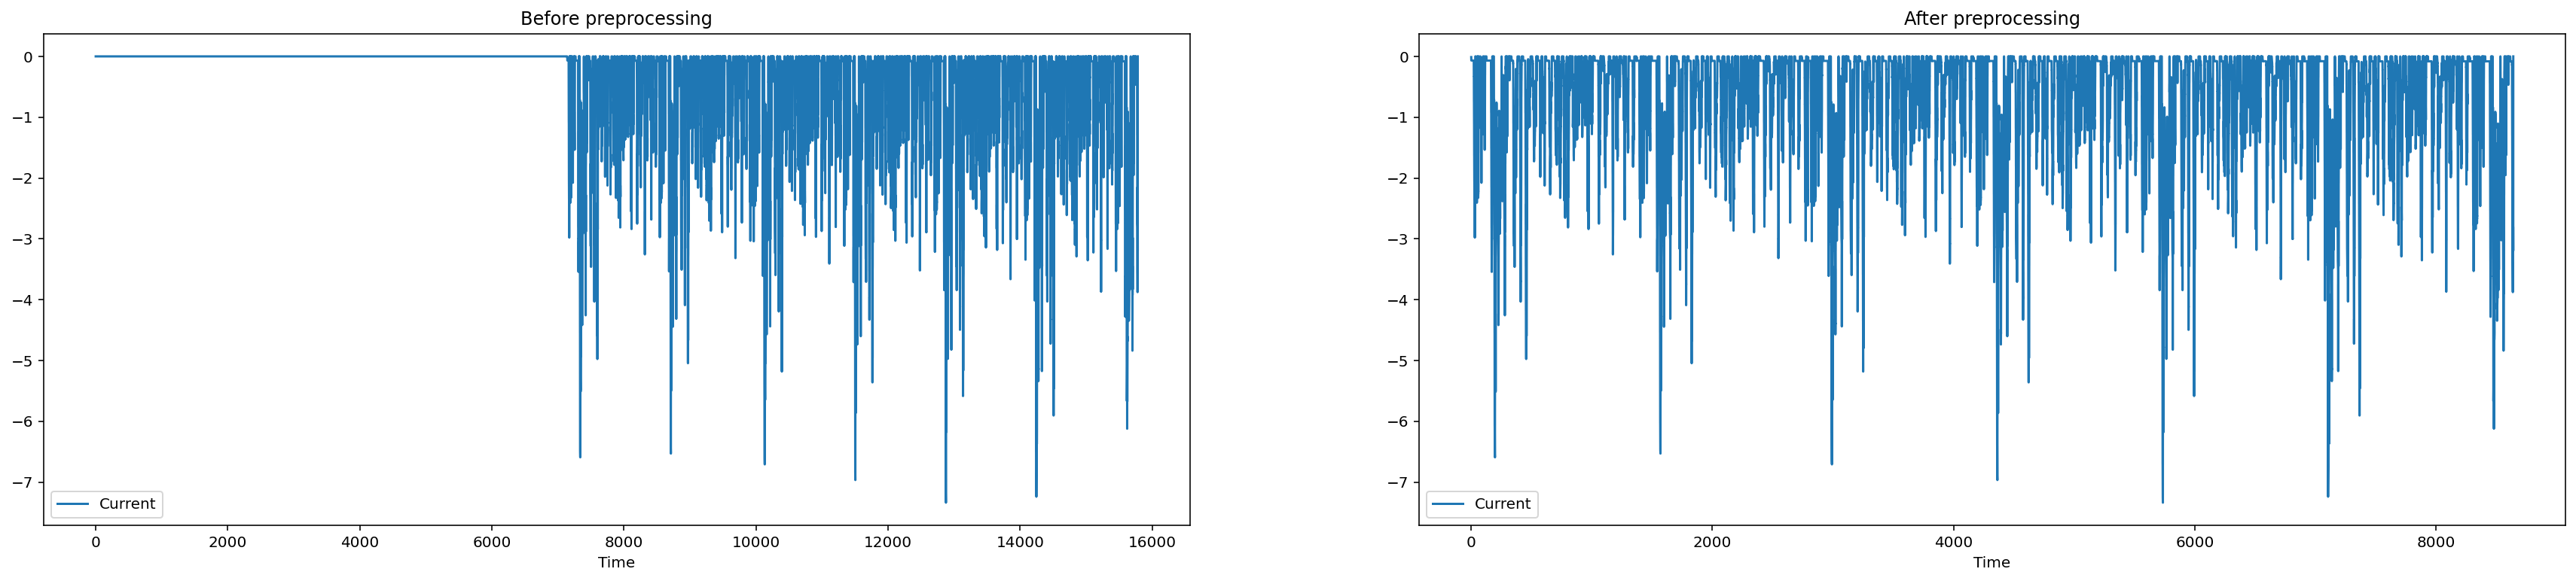

Read from 25_UDDS.csv
Start from 0
Save to 25_UDDS.pickle


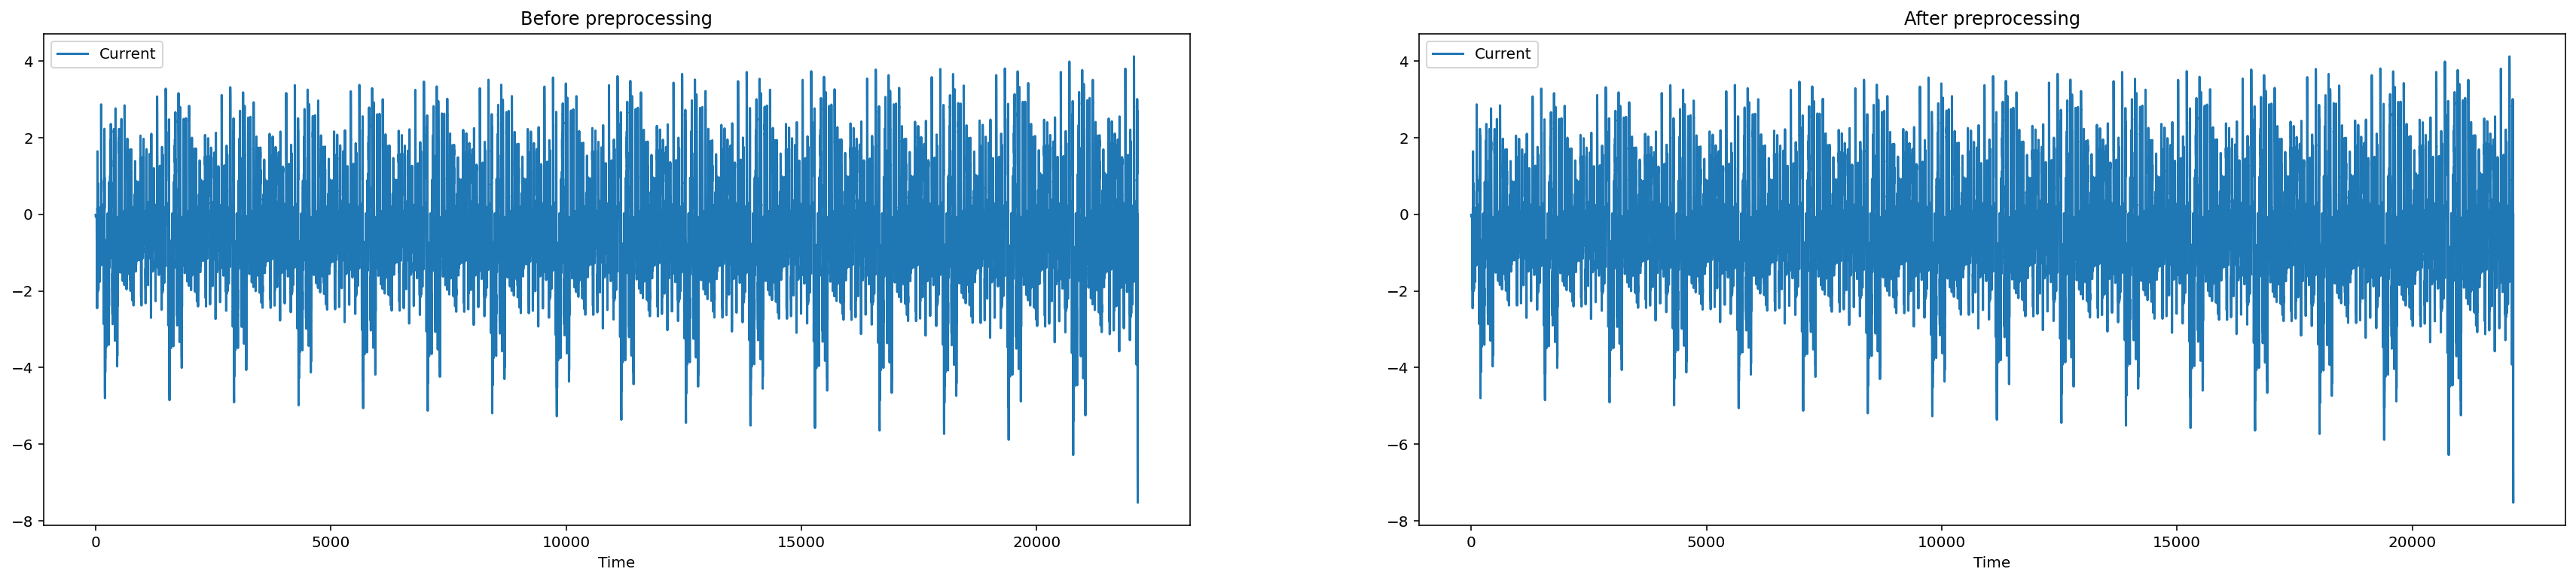

In [8]:
test_files = ROOT_DIR.glob("input/test/*.csv")
for test_file in test_files:
    df = pd.read_csv(test_file, index_col=0)
    print(f"Read from {test_file.name}")
    fig, ax = plt.subplots(ncols=2, figsize=(30, 6))
    df.plot(x="Time", y="Current", ax=ax[0])
    ax[0].set_title("Before preprocessing")
    
    # Currentが増加したタイミングを、実験開始の (SOCが減り始める) タイミングと判定
    exp_start_idx = df.query("Current != 0.0").index[0]
    print(f"Start from {exp_start_idx}")
    df = df.iloc[exp_start_idx:]
    df.reset_index(drop=True, inplace=True)
    df.loc[:, "Time"] = df["Time"] - df["Time"].iloc[0]  # Time (経過時間) を振り直す
    df.plot(x="Time", y="Current", ax=ax[1])
    ax[1].set_title("After preprocessing")
    save_file_name = OUT_DIR.joinpath("test", test_file.name).with_suffix(".pickle")
    
    # Currentが増加するまでの部分を除去して保存する
    print(f"Save to {save_file_name.name}")
    df.to_pickle(save_file_name)
    plt.show()

## 3. 学習時に利用する設定ファイルを準備する

### 学習データの温度条件ごとのファイルのパス

In [9]:
train_files = OUT_DIR.glob("train/*.pickle")
train_temp2fn = {}
for train_file in train_files:
    df = pd.read_pickle(train_file)
    _temp_degc = df['Chamber_Temp_degC'].unique()[0]
    train_temp2fn.setdefault(str(_temp_degc), [])
    train_temp2fn[str(_temp_degc)].append(str(train_file))

In [10]:
save_filename = CONFIG_DIR.joinpath("train_temp2fn.json")
with open(save_filename, "w") as f:
    json.dump(train_temp2fn, f, indent=4)

### テストデータの温度条件ごとのファイルのパス

In [11]:
test_files = OUT_DIR.glob("test/*.pickle")
test_temp2fn = {}
for test_file in test_files:
    df = pd.read_pickle(test_file)
    _temp_degc = df['Chamber_Temp_degC'].unique()[0]
    test_temp2fn.setdefault(str(_temp_degc), [])
    test_temp2fn[str(_temp_degc)].append(str(test_file))

In [12]:
save_filename = CONFIG_DIR.joinpath("test_temp2fn.json")
with open(save_filename, "w") as f:
    json.dump(test_temp2fn, f, indent=4)